In [448]:
import pandas as pd
import seaborn as sns
import re

In [449]:
df_whole = pd.read_csv('../data/processed/02_cleaned_data.csv', index_col=0)

In [450]:
df_whole.shape

(975, 836)

In [451]:
df_whole.head()

,AP1. Wie alt sind Sie?,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_10.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,...,W7[SQ004]. Welche Form von Vergütung erhalten Sie? [Weihnachtsgeld],W7[SQ005]. Welche Form von Vergütung erhalten Sie? [Urlaubsgeld],W7[SQ006]. Welche Form von Vergütung erhalten Sie? [Sachwerte],W8[SQ001]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Arbeitszeitausgleich],W8[SQ002]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Bezahlung],W8[SQ003]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Sachwerte],W8[SQ004]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Gar nicht],W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_1,W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_Teils,id. Antwort ID
0,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,953
1,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,24
2,4.0,False,False,False,False,False,True,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,57
3,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,65
4,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,93


# Correlation Analysis

In [452]:
# Calculate the correlation matrix
corr_matrix = df_whole.corr(method='pearson')

# Gather unique pairs of correlations
correlations = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # Start from i+1 to avoid duplicates and self-correlations
        correlations.append([corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]])

# Create a DataFrame to hold the correlations
corr_df = pd.DataFrame(correlations, columns=['Column1', 'Column2', 'CorrelationCoefficient'])

print(corr_df)

                                                  Column1  \
0                                  AP1. Wie alt sind Sie?   
1                                  AP1. Wie alt sind Sie?   
2                                  AP1. Wie alt sind Sie?   
3                                  AP1. Wie alt sind Sie?   
4                                  AP1. Wie alt sind Sie?   
...                                                   ...   
349025  W8[SQ004]. Wie werden zusätzlich geleistete Ar...   
349026  W8[SQ004]. Wie werden zusätzlich geleistete Ar...   
349027  W9. Bekommen Sie Ihre Vergütung pünktlich zum ...   
349028  W9. Bekommen Sie Ihre Vergütung pünktlich zum ...   
349029  W9. Bekommen Sie Ihre Vergütung pünktlich zum ...   

                                                  Column2  \
0                              AP1. Wie alt sind Sie?_0.0   
1                              AP1. Wie alt sind Sie?_1.0   
2                             AP1. Wie alt sind Sie?_10.0   
3                      

In [453]:
print(corr_df.head())
len(corr_df)

                  Column1                      Column2  CorrelationCoefficient
0  AP1. Wie alt sind Sie?   AP1. Wie alt sind Sie?_0.0               -0.170962
1  AP1. Wie alt sind Sie?   AP1. Wie alt sind Sie?_1.0               -0.438887
2  AP1. Wie alt sind Sie?  AP1. Wie alt sind Sie?_10.0                0.238561
3  AP1. Wie alt sind Sie?   AP1. Wie alt sind Sie?_2.0               -0.456681
4  AP1. Wie alt sind Sie?   AP1. Wie alt sind Sie?_3.0               -0.120230


349030

In [454]:
corr_df_sorted = corr_df.sort_values(by='CorrelationCoefficient')

In [455]:
significant_corr_df =  corr_df[(corr_df['CorrelationCoefficient']>0.7) | (corr_df['CorrelationCoefficient']<-0.7)]
len(significant_corr_df)

549

In [456]:
significant_corr_df.to_csv('../data/processed/03_significant_correlations.csv')
corr_df.to_csv('../data/processed/03_all_correlations.csv')

# visualizations

## functions

In [457]:
def cross_analysis_one_hot(cols_first:list, cols_second:list, df=df_whole):
    """
    Perform cross analysis between two sets of one-hot encoded columns.

    This function calculates the sum and percentage of occurrences for each combination
    of values in two lists of columns within a given DataFrame. It's particularly useful
    for analyzing the relationship between two one-hot encoded questions by generating
    a new DataFrame that summarizes these relationships.

    Parameters:
    - cols_first (list of str): Column names to be used as the index of the new DataFrame.
        These columns should be one-hot encoded and represent the first question/set of options.
    - cols_second (list of str): Column names to be used as columns of the new DataFrame.
        These columns should be one-hot encoded and represent the second question/set of options.
    - df (pd.DataFrame, optional): The DataFrame containing the columns specified in
        `cols_first` and `cols_second`. Defaults to `df_whole` if not specified.

    Returns:
    - pd.DataFrame: A DataFrame with index as `cols_first` and columns as `cols_second`,
        containing sum and percentage values for each index-column combination.
    - list: A list of the names of the percentage columns in the returned DataFrame,
        which can be used for further analysis or visualization.

    Example:
    >>> cols_first = ['Question1_OptionA', 'Question1_OptionB']
    >>> cols_second = ['Question2_OptionA', 'Question2_OptionB']
    >>> analysis_df, percentage_cols = cross_analysis_one_hot(cols_first, cols_second, df=my_dataframe)
    This will return a DataFrame with the cross analysis of specified options and
    a list of column names representing the percentage values.
    """
    
    # initialize empty DataFrame
    aggregated_df = pd.DataFrame(index=cols_first, columns=cols_second).fillna(0)

    for level_index in cols_first:
        for level_cols in cols_second:
            # Sum the age counts for the current career path
            aggregated_df.loc[level_index, level_cols] = df[df[level_index] == True][level_cols].sum()
        
    # rename indices and column names
    aggregated_df.columns = cols_second

    #aggregated_df.index = career
    aggregated_df['totals'] = aggregated_df.sum(axis=1)
    
    ls_perc_columns = []
    for col in aggregated_df.loc[:, aggregated_df.columns != 'totals'].columns:
        percentage_column_name = f'{col}Percentage'
        ls_perc_columns.append(percentage_column_name)
        aggregated_df[percentage_column_name] = (aggregated_df[col] / aggregated_df['totals']) * 100
    
    
    return aggregated_df, ls_perc_columns

In [458]:
def cross_analysis_non_one_hot(col_name:str, oh_cols:list, df=df_whole, transpose=False):
    """
    Performs aggregation and analysis on a dataset based on a specified non-one-hot-encoded column 
    against multiple one-hot-encoded columns. It calculates the sum and percentage of True values 
    for each one-hot-encoded column grouped by the unique values in the non-one-hot-encoded column.

    Parameters:
    - col_name (str): The name of the non-one-hot-encoded column to group the data by.
    - oh_cols (list of str): A list containing the names of the one-hot-encoded columns to be analyzed.
    - df (pd.DataFrame, optional): The DataFrame to perform the analysis on. Defaults to `df_whole`.
    - transpose (bool, optional): If set to True, the resulting DataFrame is transposed, 
      making the aggregated categories the columns instead of the rows. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame with aggregated sum and percentage values for each category 
      in the non-one-hot-encoded column. If `transpose` is True, the DataFrame is transposed.
    - list: A list of the names of the percentage columns in the returned DataFrame, 
      which can be used for further analysis or visualization.

    The resulting DataFrame includes a 'totals' column that sums the occurrences for all 
    one-hot-encoded columns, and additional columns representing the percentage of each 
    one-hot-encoded column's True values relative to the 'totals'.

    Example:
    >>> col_name = 'Department'
    >>> oh_cols = ['ProjectCompleted', 'ProjectInProgress']
    >>> aggregated_df, percentage_cols = cross_analysis_non_one_hot(col_name, oh_cols, df=my_dataframe)
    >>> print(aggregated_df)
    
    This example would group `my_dataframe` by 'Department', aggregating data for 'ProjectCompleted' 
    and 'ProjectInProgress', and calculating the percentage of each within departments.
    """
    
    # Initialize aggregation dictionary
    agg_dict = {col: pd.NamedAgg(column=col, aggfunc='sum') for col in oh_cols}
    
    # Aggregate the data
    df_aggregated = df.groupby(col_name).agg(**agg_dict).reset_index()
    
    if transpose == False:
        # Calculate totals
        df_aggregated['totals'] = df_aggregated[oh_cols].sum(axis=1)

        # Calculate percentages for each contract type
        ls_perc_columns = []
        for col in oh_cols:
            percentage_col = f'{col}Perc'
            ls_perc_columns.append(percentage_col)
            df_aggregated[percentage_col] = (df_aggregated[col] / df_aggregated['totals']) * 100
            df_aggregated[percentage_col].fillna(0, inplace=True)  # Handle division by zero
    
    else: #Todo:write process for transposed data
        df_aggregated = df_aggregated.T
        df_aggregated.columns = [f"{df_aggregated.index[0]}_{df_aggregated.iloc[0, i]}_sum" for i in range(len(df_aggregated.columns))]
        df_aggregated.drop(index=df_aggregated.index[0], axis=0, inplace=True)
        df_aggregated['totals'] = df_aggregated.sum(axis=1)
        
        ls_perc_columns = []
        for col in df_aggregated.columns:
            if col != 'totals':
                percentage_col = f'{col}Perc'
                ls_perc_columns.append(percentage_col)
                df_aggregated[percentage_col] = (df_aggregated[col] / df_aggregated['totals']) * 100
                df_aggregated[percentage_col].fillna(0, inplace=True)  # Handle division by zero
        

    return df_aggregated, ls_perc_columns

In [459]:
def inversed_legend(ls_categories_legend):
    # Assuming pand_effect_levels contains the legend labels in the original order
    # Reverse the order of labels to match the visual stacking order in the plot
    reversed_labels = ls_categories_legend[::-1]

    # Get the current handles from the plot
    handles, _ = ax.get_legend_handles_labels()

    # Reverse the order of handles to match the reversed order of labels
    reversed_handles = handles[::-1]

    # Set the new legend with reversed handles and labels
    ax.legend(reversed_handles, reversed_labels, loc='center left', bbox_to_anchor=(1, 0.75))

In [460]:
def extract_last_bracket(string:str):
    # The string from which to extract the content
    text = string

    # Regular expression to find content within square brackets
    matches = re.findall(r'\[(.*?)\]', text)

    # Extract the content of the second set of square brackets and remove trailing whitespace
    content = matches[1].strip() if len(matches) > 1 else None

    return content

## try out scatter plot

In [461]:
significant_corr_df.iloc[0][1]

/tmp/ipykernel_31005/2159218889.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  significant_corr_df.iloc[0][1]


'AP5r[SQ002]. Bitte machen Sie folgende Angaben:\xa0 [In wie vielen Berufsjahren insgesamt (Jahre in Ziffern)? ]'

/tmp/ipykernel_31005/1352033493.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x=significant_corr_df.iloc[0][0],
/tmp/ipykernel_31005/1352033493.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=significant_corr_df.iloc[0][1],


<Axes: xlabel='AP1. Wie alt sind Sie?', ylabel='AP5r[SQ002]. Bitte machen Sie folgende Angaben:\xa0 [In wie vielen Berufsjahren insgesamt (Jahre in Ziffern)? ]'>

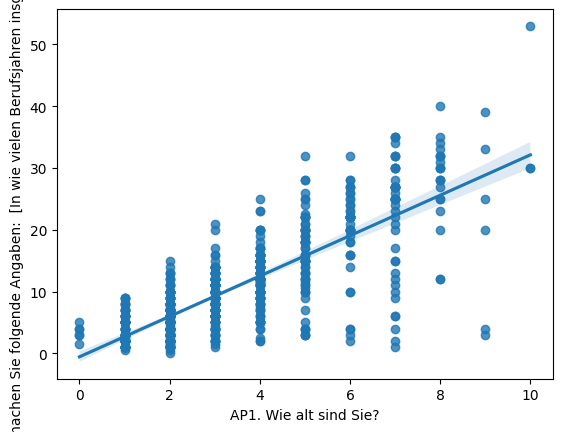

In [462]:
sns.regplot(data=df_whole, 
            x=significant_corr_df.iloc[0][0], 
            y=significant_corr_df.iloc[0][1],
            ci=95)

## fixed term vs permanent contracts Museum

In [463]:
#extract columns with education levels
ls_cols_education_level = [col for col in df_whole if col.startswith('AP2[')]
ls_cols_contract = [col for col in df_whole if col.startswith('M9.')]

#extract education levels
# Regular expression to find a string inside square brackets at the end of column
pattern = re.compile(r'\[([^\]]*)\]$')
strings_inside_brackets = [pattern.search(col).group(1) if pattern.search(col) else None for col in ls_cols_education_level]
print(strings_inside_brackets)

['Bachelor of Arts: ', 'Master of Arts:', 'Magister Artium:', 'I. Staatsexamen:', 'II. Staatsexamen:', 'Diplom:', 'Dr. phil.:', 'Dr. phil. habil. bzw. PD:', 'Sonstiges:', 'Ausländischer akademischer Grad:']


In [464]:
edu_con_df, educ_con_cols_perc = cross_analysis_one_hot(ls_cols_education_level, ls_cols_contract)
edu_con_df

,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.",totals,M9. Sind Sie momentan befristet beschäftigt? _1Percentage,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.Percentage"
AP2[SQ001]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Bachelor of Arts: ],41,12,53,77.358491,22.641509
AP2[SQ002]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Master of Arts:],129,47,176,73.295455,26.704545
AP2[SQ003]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Magister Artium:],40,58,98,40.816327,59.183673
AP2[SQ004]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [I. Staatsexamen:],1,1,2,50.000000,50.000000
AP2[SQ005]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [II. Staatsexamen:],0,1,1,0.000000,100.000000
AP2[SQ006]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Diplom:],3,2,5,60.000000,40.000000
AP2[SQ007]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Dr. phil.:],49,70,119,41.176471,58.823529
AP2[SQ008]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Dr. phil. habil. bzw. PD:],2,1,3,66.666667,33.333333
AP2[SQ009]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Sonstiges:],4,4,8,50.000000,50.000000
AP2[SQ010]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Ausländischer akademischer Grad:],1,3,4,25.000000,75.000000


In [465]:
levels_contract = ['befristeter Vertrag', 'unbefristeter Vertrag']

Text(1.02, 0.985, 'Gesamtzahl')

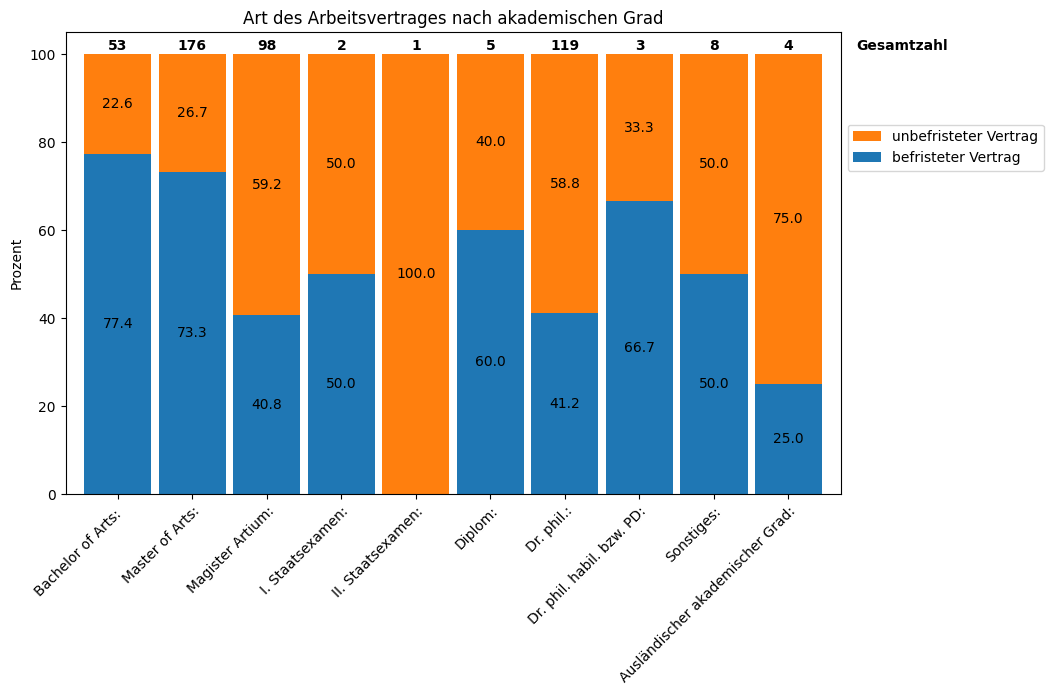

In [466]:
ax = edu_con_df[educ_con_cols_perc].plot(kind='bar', 
                                        stacked=True, 
                                        figsize=(10, 6), 
                                        rot=45, ylabel='Prozent', 
                                        width=0.9, 
                                        title='Art des Arbeitsvertrages nach akademischen Grad'
                                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(edu_con_df['totals']):
    ax.text(edu_con_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.set_xticklabels(strings_inside_brackets, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(levels_contract)

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
    

In [467]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_00_Abschluss_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

## fixed term or permanent contracts by age group

In [468]:
ls_cols_age_level = [col for col in df_whole if col.startswith('AP1.') & col.endswith('.0')]
#the order of age levels needs to be sorted by hand, since age level 10 is not placed at the end of list
order = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 2]
ls_cols_age_level = [ls_cols_age_level[i] for i in order]
decoded_age_level = ['Unter 25',
                     '25-29',
                     '30-34',
                     '35-39',
                     '40-44',
                     '45-49',
                     '50-54',
                     '55-59',
                     '60-64',
                     '65-69',
                     'Über 70']

In [469]:
ls_cols_age_level

['AP1. Wie alt sind Sie?_0.0',
 'AP1. Wie alt sind Sie?_1.0',
 'AP1. Wie alt sind Sie?_2.0',
 'AP1. Wie alt sind Sie?_3.0',
 'AP1. Wie alt sind Sie?_4.0',
 'AP1. Wie alt sind Sie?_5.0',
 'AP1. Wie alt sind Sie?_6.0',
 'AP1. Wie alt sind Sie?_7.0',
 'AP1. Wie alt sind Sie?_8.0',
 'AP1. Wie alt sind Sie?_9.0',
 'AP1. Wie alt sind Sie?_10.0']

In [470]:
age_con_df, age_con_perc_col = cross_analysis_one_hot(ls_cols_age_level, ls_cols_contract)
age_con_df

,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.",totals,M9. Sind Sie momentan befristet beschäftigt? _1Percentage,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.Percentage"
AP1. Wie alt sind Sie?_0.0,3,1,4,75.000000,25.000000
AP1. Wie alt sind Sie?_1.0,40,9,49,81.632653,18.367347
AP1. Wie alt sind Sie?_2.0,81,29,110,73.636364,26.363636
AP1. Wie alt sind Sie?_3.0,45,33,78,57.692308,42.307692
AP1. Wie alt sind Sie?_4.0,35,26,61,57.377049,42.622951
AP1. Wie alt sind Sie?_5.0,9,23,32,28.125000,71.875000
AP1. Wie alt sind Sie?_6.0,2,13,15,13.333333,86.666667
AP1. Wie alt sind Sie?_7.0,5,21,26,19.230769,80.769231
AP1. Wie alt sind Sie?_8.0,1,11,12,8.333333,91.666667
AP1. Wie alt sind Sie?_9.0,0,1,1,0.000000,100.000000


Text(1.02, 0.985, 'Gesamtzahl')

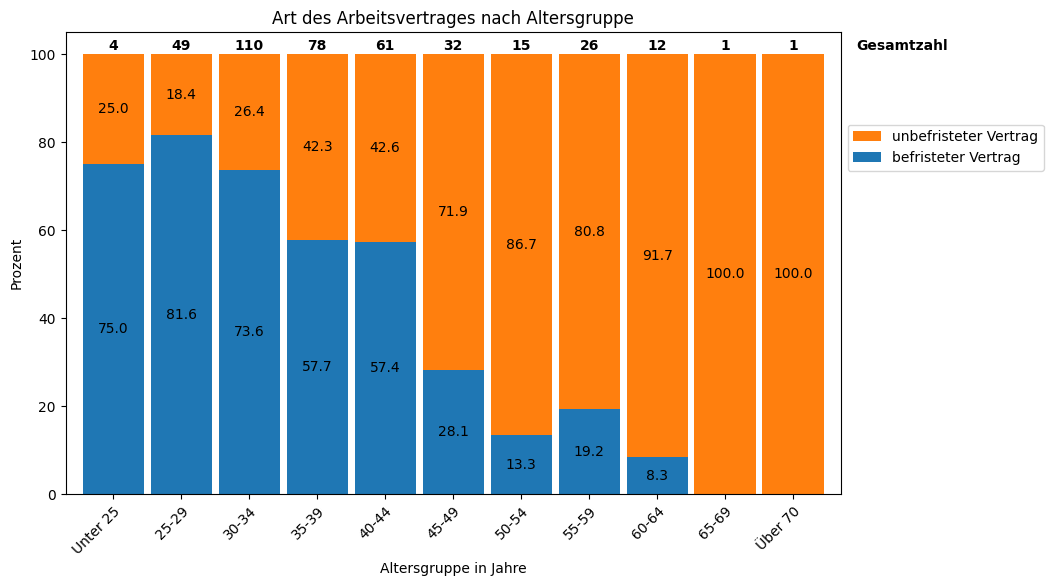

In [471]:
ax = age_con_df[age_con_perc_col].plot(kind='bar', 
                                        stacked=True, 
                                        figsize=(10, 6), 
                                        rot=45, ylabel='Prozent', 
                                        width=0.9, 
                                        title='Art des Arbeitsvertrages nach Altersgruppe',
                                        xlabel='Altersgruppe in Jahre'
                                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(age_con_df['totals']):
    ax.text(age_con_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.set_xticklabels(decoded_age_level, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(levels_contract)

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [472]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_01_Alter_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

## working contract vs being first academic

In [473]:
con_acad_df, con_acad_perc = cross_analysis_non_one_hot('CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?', ls_cols_contract)

In [474]:
con_acad_df

,CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.",totals,M9. Sind Sie momentan befristet beschäftigt? _1Perc,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.Perc"
0,0.0,130,90,220,59.090909,40.909091
1,1.0,86,77,163,52.760736,47.239264


Text(1.02, 0.985, 'Gesamtzahl')

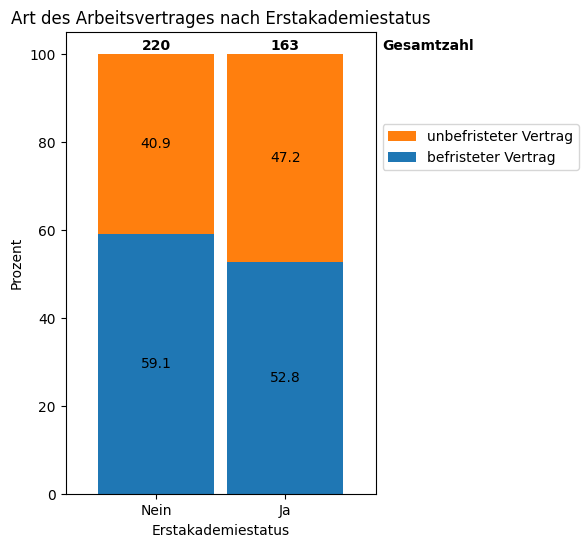

In [475]:
ax = con_acad_df[con_acad_perc].plot(kind='bar', 
                                        stacked=True, 
                                        figsize=(4, 6), 
                                        rot=45, ylabel='Prozent', 
                                        width=0.9, 
                                        title='Art des Arbeitsvertrages nach Erstakademiestatus',
                                        xlabel='Erstakademiestatus'
                                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(con_acad_df['totals']):
    ax.text(con_acad_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.set_xticklabels(['Nein', 'Ja'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_contract)

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [476]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_02_Erstakademiker_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

#### working contract vs first language German

In [477]:
con_lang_df, con_lang_perc = cross_analysis_non_one_hot('CO4. Ist\xa0Deutsch Ihre Erstsprache?', ls_cols_contract)

In [478]:
con_lang_df

,CO4. Ist Deutsch Ihre Erstsprache?,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.",totals,M9. Sind Sie momentan befristet beschäftigt? _1Perc,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.Perc"
0,0.0,12,5,17,70.588235,29.411765
1,1.0,212,167,379,55.936675,44.063325


Text(1.02, 0.985, 'Gesamtzahl')

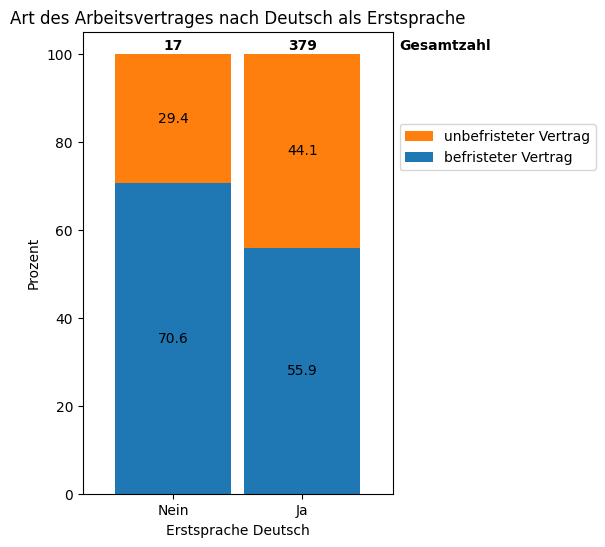

In [479]:
ax = con_lang_df[con_lang_perc].plot(kind='bar', 
                                        stacked=True, 
                                        figsize=(4, 6), 
                                        rot=45, ylabel='Prozent', 
                                        width=0.9, 
                                        title='Art des Arbeitsvertrages nach Deutsch als Erstsprache',
                                        xlabel='Erstsprache Deutsch'
                                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(con_lang_df['totals']):
    ax.text(con_lang_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.set_xticklabels(['Nein', 'Ja'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_contract)

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [480]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_03_Erstsprache_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

## working contract vs gender

In [481]:
ls_cols_gender = [col for col in df_whole if col.startswith('CO6.')]

con_gender_df, con_gender_perc = cross_analysis_one_hot(ls_cols_gender, ls_cols_contract)
con_gender_df

,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.",totals,M9. Sind Sie momentan befristet beschäftigt? _1Percentage,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.Percentage"
CO6. Welchem Geschlecht ordnen Sie sich zu?_Divers,1,0,1,100.00000,0.00000
CO6. Welchem Geschlecht ordnen Sie sich zu?_Männlich,28,43,71,39.43662,60.56338
CO6. Welchem Geschlecht ordnen Sie sich zu?_Weiblich,194,129,323,60.06192,39.93808


In [482]:
gender_levels = ['Divers', 'Männlich', 'Weiblich']

Text(1.02, 0.985, 'Gesamtzahl')

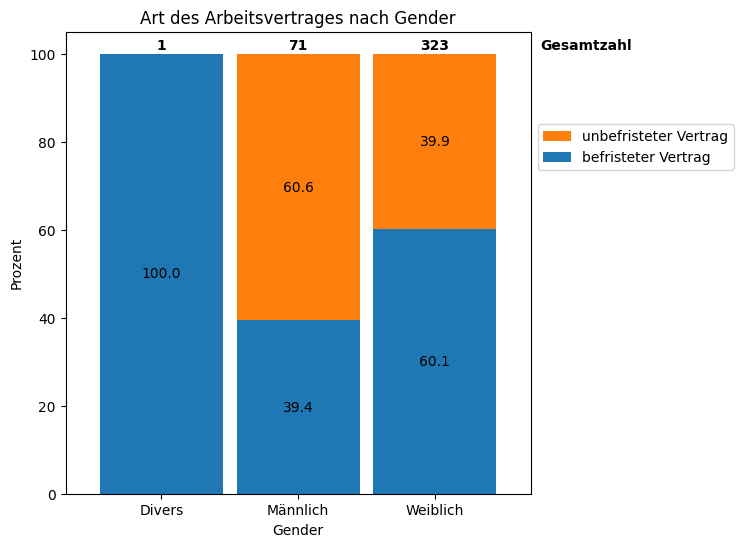

In [483]:
ax = con_gender_df[con_gender_perc].plot(kind='bar', 
                                        stacked=True, 
                                        figsize=(6, 6), 
                                        rot=45, ylabel='Prozent', 
                                        width=0.9, 
                                        title='Art des Arbeitsvertrages nach Gender',
                                        xlabel='Gender'
                                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(con_gender_df['totals']):
    ax.text(con_gender_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.set_xticklabels(gender_levels, rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_contract)

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [484]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_04_Gender_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

## bullying vs career type

In [485]:
#extract columns with career and bullying
ls_cols_career = [col for col in df_whole if col.startswith('AP14')]
ls_cols_bullying = [col for col in df_whole if col.startswith('CO7r')]

#extract career levels
career = [entry.split('Fragen:\xa0_')[1] for entry in ls_cols_career]
print(career)
print(ls_cols_career)

#extract bullying levels
# Regular expression to find a string inside square brackets at the end of column
pattern = re.compile(r'\[([^\]]*)\]$')
bullying_levels = [pattern.search(col).group(1) if pattern.search(col) else None for col in ls_cols_bullying]
print(bullying_levels)

['Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit', 'Freiberufler:in', 'Freie Wirtschaft', 'Museums- oder Ausstellungswesen und Denkmalpflege', 'Stipendiat:in', 'Universität, Hochschule oder außeruniversitäre Forschungseinrichtung']
['AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0_Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit', 'AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für S

In [486]:
car_bul_df, car_bul_perc = cross_analysis_non_one_hot('CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt?\xa0\xa0',
                                                      ls_cols_career,
                                                      transpose=True)

In [487]:
car_bul_df

,"CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt? _0.0_sum","CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt? _1.0_sum",totals,"CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt? _0.0_sumPerc","CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt? _1.0_sumPerc"
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",33.0,37.0,70.0,47.142857,52.857143
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",58.0,48.0,106.0,54.716981,45.283019
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",30.0,14.0,44.0,68.181818,31.818182
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",252.0,122.0,374.0,67.379679,32.620321
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",25.0,17.0,42.0,59.523810,40.476190
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",172.0,97.0,269.0,63.940520,36.059480


In [488]:
levels_exp_bullying = ['Keine Mobbingerfahrung', 'Mobbingerfahrung']

Text(1.02, 0.985, 'Gesamtzahl')

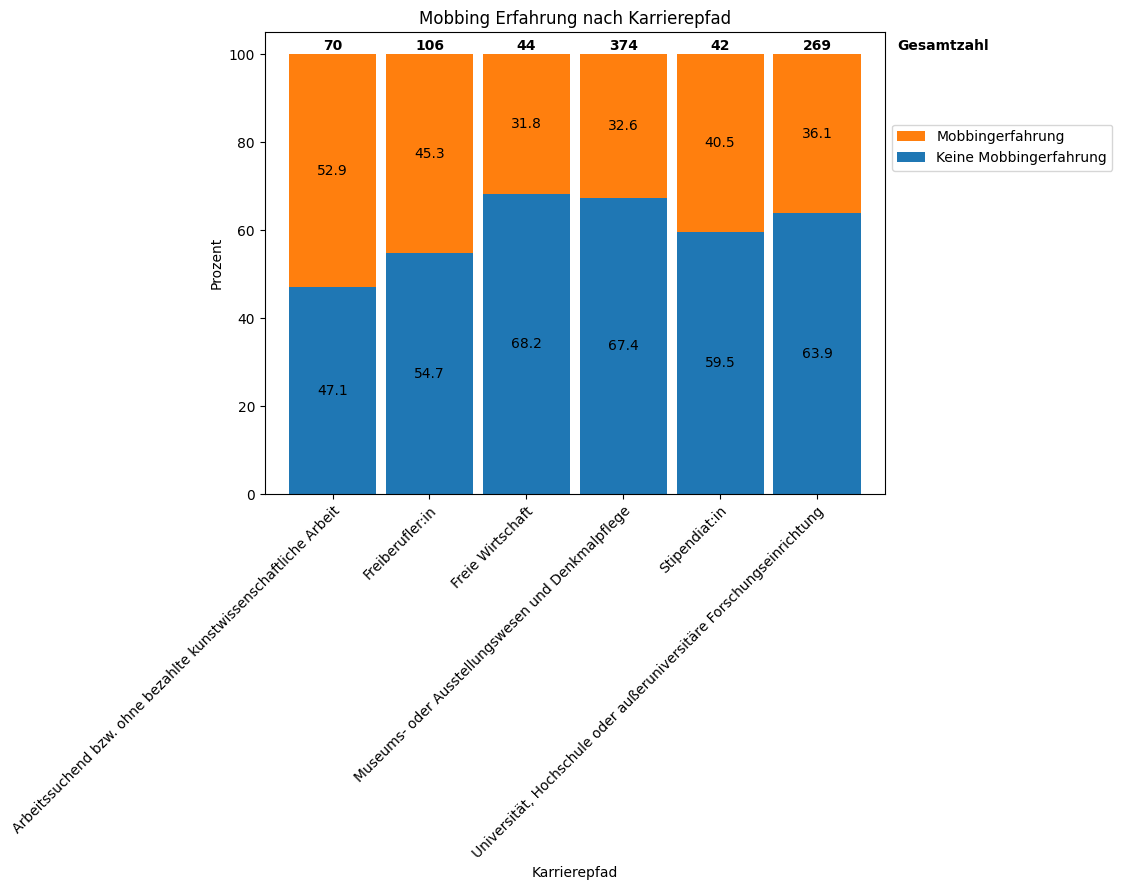

In [489]:
ax = car_bul_df[car_bul_perc].plot(kind='bar', 
                                    stacked=True, 
                                    figsize=(8, 6),                                                                                        
                                    ylabel='Prozent',
                                    xlabel='Karrierepfad',
                                    width=0.9,
                                    title='Mobbing Erfahrung nach Karrierepfad'
                                    )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(career, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(levels_exp_bullying)
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(car_bul_df['totals']):
    ax.text(car_bul_df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [490]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_00_Pfad_vs_Mobbing.png', bbox_inches='tight', dpi=300)

In [491]:
ls_cols_bullying

['CO7r[SQ001]. Aus welchen Gründen? [Abschluss oder akademischer Grad]',
 'CO7r[SQ002]. Aus welchen Gründen? [Alter ]',
 'CO7r[SQ003]. Aus welchen Gründen? [Beeinträchtigung bzw. chronische Krankheit ]',
 'CO7r[SQ004]. Aus welchen Gründen? [Care-Verpflichtungen: Kinder]',
 'CO7r[SQ005]. Aus welchen Gründen? [Care-Verpflichtungen: pflegebedürftige Angehörige]',
 'CO7r[SQ006]. Aus welchen Gründen? [Erstsprache ]',
 'CO7r[SQ007]. Aus welchen Gründen? [Geschlecht bzw. Geschlechtsidentität]',
 'CO7r[SQ008]. Aus welchen Gründen? [Klasse (z.B. Erstakademiker:in)]',
 'CO7r[SQ009]. Aus welchen Gründen? [Konkurrenzkämpfe]',
 'CO7r[SQ010]. Aus welchen Gründen? [Rassifizierende Zuschreibung]',
 'CO7r[SQ011]. Aus welchen Gründen? [Religion bzw. Weltanschauung (inklusive Zuschreibungen)]',
 'CO7r[SQ012]. Aus welchen Gründen? [Sexuelle Identität bzw. Orientierung (inklusive Zuschreibungen)]',
 'CO7r[SQ013]. Aus welchen Gründen? [Staatsangehörigkeit]']

### bullying types vs career paths

In [492]:
car_bul_types_df, car_bul_types_perc = cross_analysis_one_hot(ls_cols_career, ls_cols_bullying)

In [493]:
car_bul_types_df

,CO7r[SQ001]. Aus welchen Gründen? [Abschluss oder akademischer Grad],CO7r[SQ002]. Aus welchen Gründen? [Alter ],CO7r[SQ003]. Aus welchen Gründen? [Beeinträchtigung bzw. chronische Krankheit ],CO7r[SQ004]. Aus welchen Gründen? [Care-Verpflichtungen: Kinder],CO7r[SQ005]. Aus welchen Gründen? [Care-Verpflichtungen: pflegebedürftige Angehörige],CO7r[SQ006]. Aus welchen Gründen? [Erstsprache ],CO7r[SQ007]. Aus welchen Gründen? [Geschlecht bzw. Geschlechtsidentität],CO7r[SQ008]. Aus welchen Gründen? [Klasse (z.B. Erstakademiker:in)],CO7r[SQ009]. Aus welchen Gründen? [Konkurrenzkämpfe],CO7r[SQ010]. Aus welchen Gründen? [Rassifizierende Zuschreibung],...,CO7r[SQ004]. Aus welchen Gründen? [Care-Verpflichtungen: Kinder]Percentage,CO7r[SQ005]. Aus welchen Gründen? [Care-Verpflichtungen: pflegebedürftige Angehörige]Percentage,CO7r[SQ006]. Aus welchen Gründen? [Erstsprache ]Percentage,CO7r[SQ007]. Aus welchen Gründen? [Geschlecht bzw. Geschlechtsidentität]Percentage,CO7r[SQ008]. Aus welchen Gründen? [Klasse (z.B. Erstakademiker:in)]Percentage,CO7r[SQ009]. Aus welchen Gründen? [Konkurrenzkämpfe]Percentage,CO7r[SQ010]. Aus welchen Gründen? [Rassifizierende Zuschreibung]Percentage,CO7r[SQ011]. Aus welchen Gründen? [Religion bzw. Weltanschauung (inklusive Zuschreibungen)]Percentage,CO7r[SQ012]. Aus welchen Gründen? [Sexuelle Identität bzw. Orientierung (inklusive Zuschreibungen)]Percentage,CO7r[SQ013]. Aus welchen Gründen? [Staatsangehörigkeit]Percentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",5,11,3,7,2,3,18,10,19,3,...,7.954545,2.272727,3.409091,20.454545,11.363636,21.590909,3.409091,2.272727,3.409091,2.272727
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",14,11,1,13,2,0,20,10,37,2,...,11.304348,1.739130,0.000000,17.391304,8.695652,32.173913,1.739130,1.739130,0.869565,1.739130
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",2,1,0,3,1,0,4,2,7,0,...,12.500000,4.166667,0.000000,16.666667,8.333333,29.166667,0.000000,0.000000,12.500000,4.166667
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",27,35,4,13,1,3,58,18,77,5,...,5.098039,0.392157,1.176471,22.745098,7.058824,30.196078,1.960784,1.176471,1.176471,3.137255
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",2,7,0,5,0,2,8,5,9,2,...,11.904762,0.000000,4.761905,19.047619,11.904762,21.428571,4.761905,0.000000,2.380952,2.380952
"AP14. Wir möchten im Folgenden ge

Text(1.02, 0.5, 'Mehrfachnennung waren möglich')

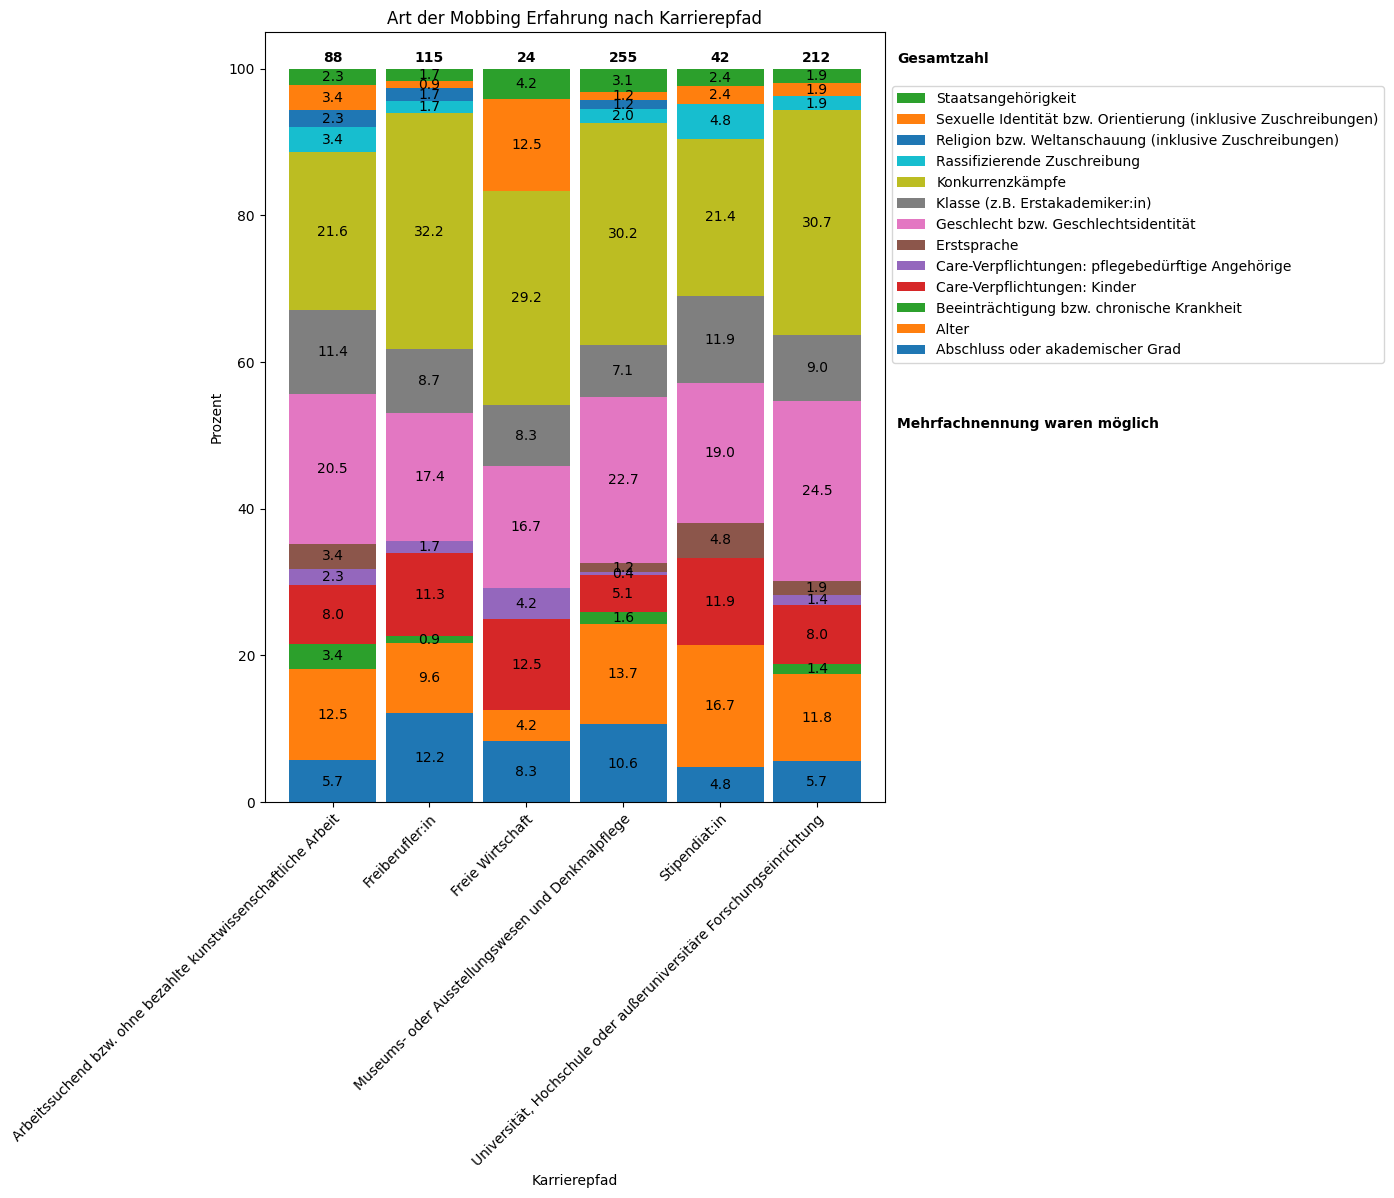

In [494]:
ax = car_bul_types_df[car_bul_types_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(8, 10),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Karrierepfad',
                        width=0.9,
                        title='Art der Mobbing Erfahrung nach Karrierepfad'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(career, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(bullying_levels)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(car_bul_types_df['totals']):
    ax.text(car_bul_types_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
ax.text(1.02, 0.5, 'Mehrfachnennung waren möglich', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [495]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_01_Pfad_vs_Mobbingarten.png', bbox_inches='tight', dpi=300)

Hypothesis: Stipendholders report more often mobbing based on their first language (CO4) and class (CO1) because there are more non-native speaker and first time academics among them. 

### career vs. first language

In [496]:
car_lang_df, car_lang_perc = cross_analysis_non_one_hot('CO4. Ist\xa0Deutsch Ihre Erstsprache?', ls_cols_career, transpose=True)

In [497]:
car_lang_df

,CO4. Ist Deutsch Ihre Erstsprache?_0.0_sum,CO4. Ist Deutsch Ihre Erstsprache?_1.0_sum,totals,CO4. Ist Deutsch Ihre Erstsprache?_0.0_sumPerc,CO4. Ist Deutsch Ihre Erstsprache?_1.0_sumPerc
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",6.0,68.0,74.0,8.108108,91.891892
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",6.0,107.0,113.0,5.309735,94.690265
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",2.0,44.0,46.0,4.347826,95.652174
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",17.0,384.0,401.0,4.239401,95.760599
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",4.0,40.0,44.0,9.090909,90.909091
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",24.0,265.0,289.0,8.304498,91.695502


In [498]:
car_lang_perc.sort(reverse=True)

In [499]:
car_lang_perc

['CO4. Ist\xa0Deutsch Ihre Erstsprache?_1.0_sumPerc',
 'CO4. Ist\xa0Deutsch Ihre Erstsprache?_0.0_sumPerc']

In [500]:
levels_lang = ['Deutsch Erstsprache', 'Deutsch keine Erstsprache']

Text(1.02, 0.985, 'Gesamtzahl')

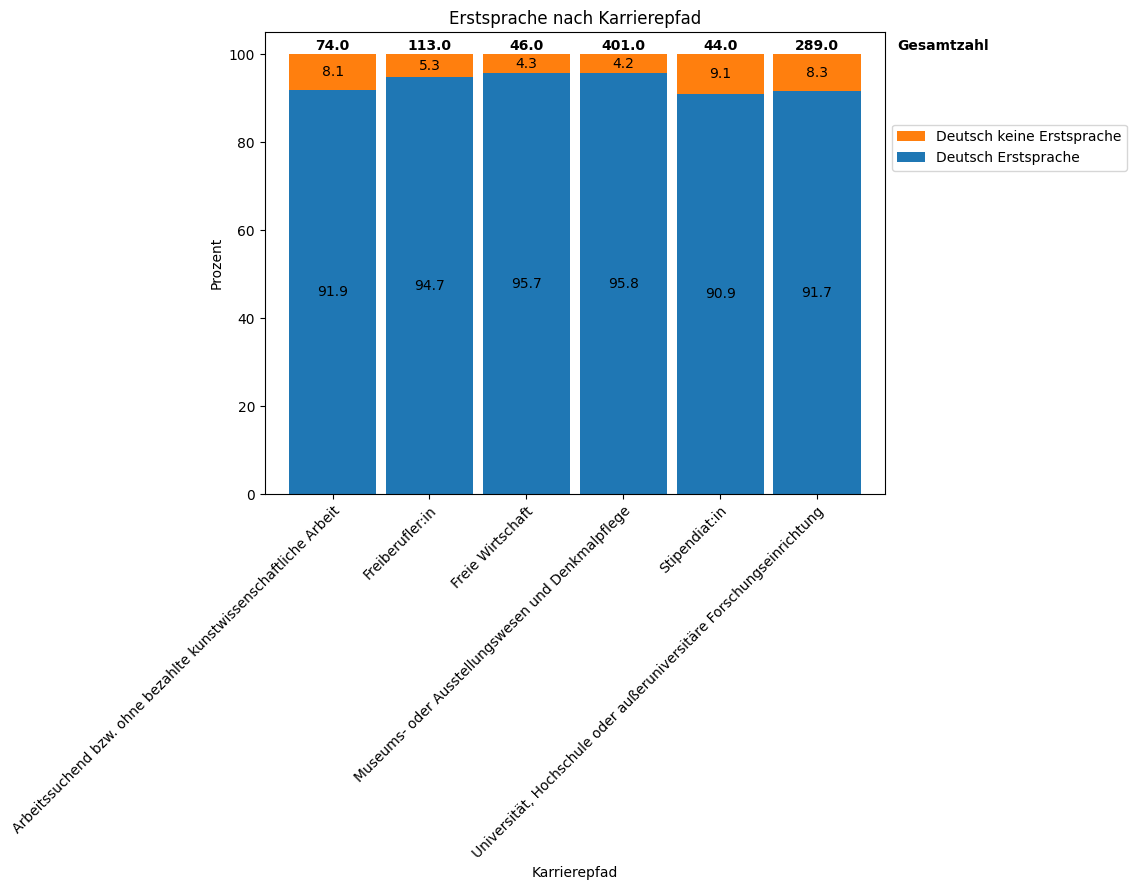

In [501]:
ax = car_lang_df[car_lang_perc].plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(8, 6),                                                                                        
                                                                                          #rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Karrierepfad',
                                                                                          width=0.9,
                                                                                          title='Erstsprache nach Karrierepfad'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(career, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(levels_lang)
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(car_lang_df['totals']):
    ax.text(car_lang_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [502]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_02_Pfad_vs_Erstsprache.png', bbox_inches='tight', dpi=300)

Yes stipend holders have the highest percentage of non-native german speaking individuals. However it's not significantly more than the population of individuals working in universities and non-university academic institutions. This does not explain why stipend holders face more bullying based on their native language.

### career vs. family background

In [503]:
car_fam_df, car_fam_perc = cross_analysis_non_one_hot('CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?', ls_cols_career, transpose=True)

In [504]:
car_fam_df

,CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?_0.0_sum,CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?_1.0_sum,totals,CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?_0.0_sumPerc,CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?_1.0_sumPerc
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",40.0,34.0,74.0,54.054054,45.945946
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",60.0,51.0,111.0,54.054054,45.945946
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",24.0,21.0,45.0,53.333333,46.666667
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",221.0,167.0,388.0,56.958763,43.041237
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",20.0,25.0,45.0,44.444444,55.555556
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",160.0,117.0,277.0,57.761733,42.238267


In [505]:
levels_fam_background = ['Nicht Erstakademiker:in', 'Erstakademiker:in']

Text(1.02, 0.985, 'Gesamtzahl')

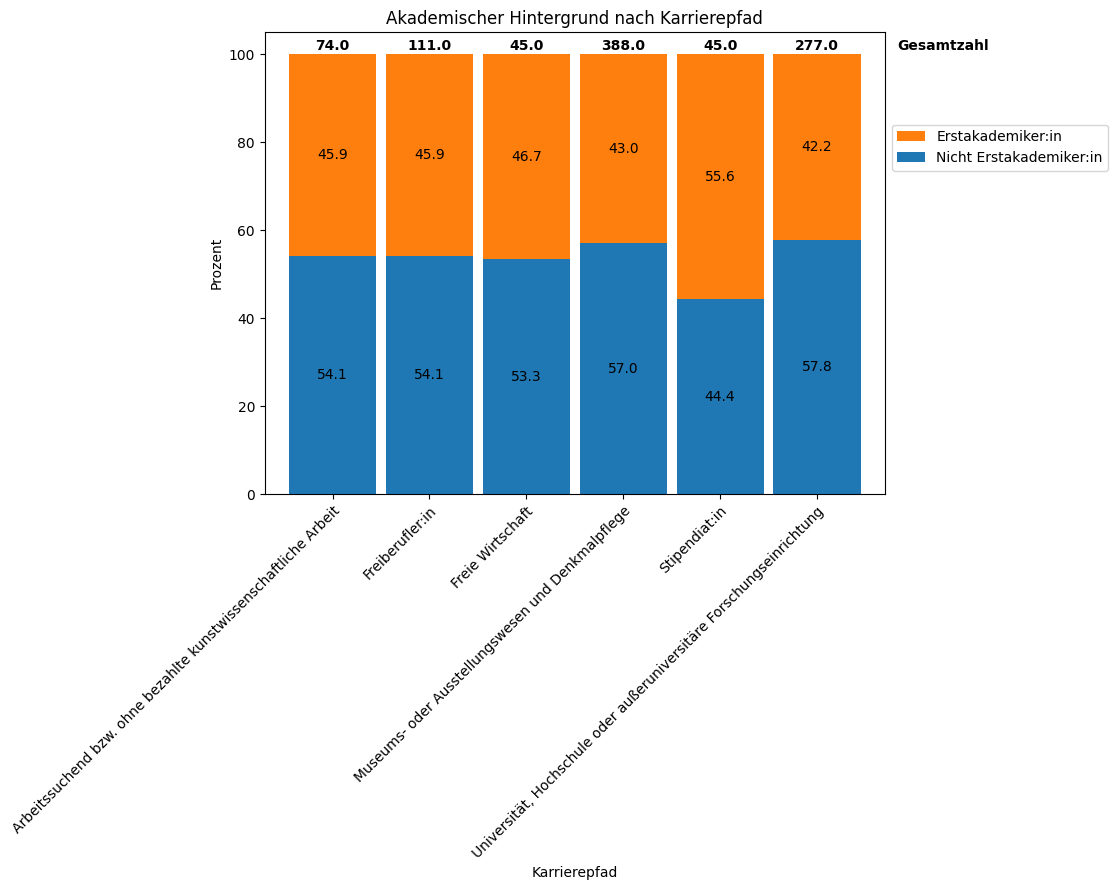

In [506]:
ax = car_fam_df[car_fam_perc].plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(8, 6),                                                                                        
                                                                                          #rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Karrierepfad',
                                                                                          width=0.9,
                                                                                          title='Akademischer Hintergrund nach Karrierepfad'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(career, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(levels_fam_background)
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(car_fam_df['totals']):
    ax.text(car_fam_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [507]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_03_Pfad_vs_Erstakademie.png', bbox_inches='tight', dpi=300)

There are indeed ~ 10% more stipend holders that report to be first in their families to have an academic degree. This could explain why there are more reported cases of classism within stipend holders.

### Career vs. Age Group

In [508]:
car_age_df, car_age_perc = cross_analysis_one_hot(ls_cols_career, ls_cols_age_level)

In [509]:
car_age_df

,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,AP1. Wie alt sind Sie?_8.0,AP1. Wie alt sind Sie?_9.0,...,AP1. Wie alt sind Sie?_1.0Percentage,AP1. Wie alt sind Sie?_2.0Percentage,AP1. Wie alt sind Sie?_3.0Percentage,AP1. Wie alt sind Sie?_4.0Percentage,AP1. Wie alt sind Sie?_5.0Percentage,AP1. Wie alt sind Sie?_6.0Percentage,AP1. Wie alt sind Sie?_7.0Percentage,AP1. Wie alt sind Sie?_8.0Percentage,AP1. Wie alt sind Sie?_9.0Percentage,AP1. Wie alt sind Sie?_10.0Percentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",0,7,23,22,7,3,8,2,1,1,...,9.459459,31.081081,29.729730,9.459459,4.054054,10.810811,2.702703,1.351351,1.351351,0.000000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",1,7,19,11,16,16,18,13,8,2,...,6.250000,16.964286,9.821429,14.285714,14.285714,16.071429,11.607143,7.142857,1.785714,0.892857
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",1,3,13,7,12,3,4,3,1,1,...,6.250000,27.083333,14.583333,25.000000,6.250000,8.333333,6.250000,2.083333,2.083333,0.000000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",4,49,110,78,62,33,15,26,12,2,...,12.436548,27.918782,19.796954,15.736041,8.375635,3.807107,6.598985,3.045685,0.507614,0.761421
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",1,8,26,7,3,0,0,0,0,0,...,17.777778,57.777778,15.555556,6.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",2,31,70,66,45,26,17,14,7,2,...,11.032028,24.911032,23.487544,16.014235,9.252669,6.049822,4.982206,2.491103,0.711744,0.355872


Text(1.02, 0.975, 'Gesamtzahl')

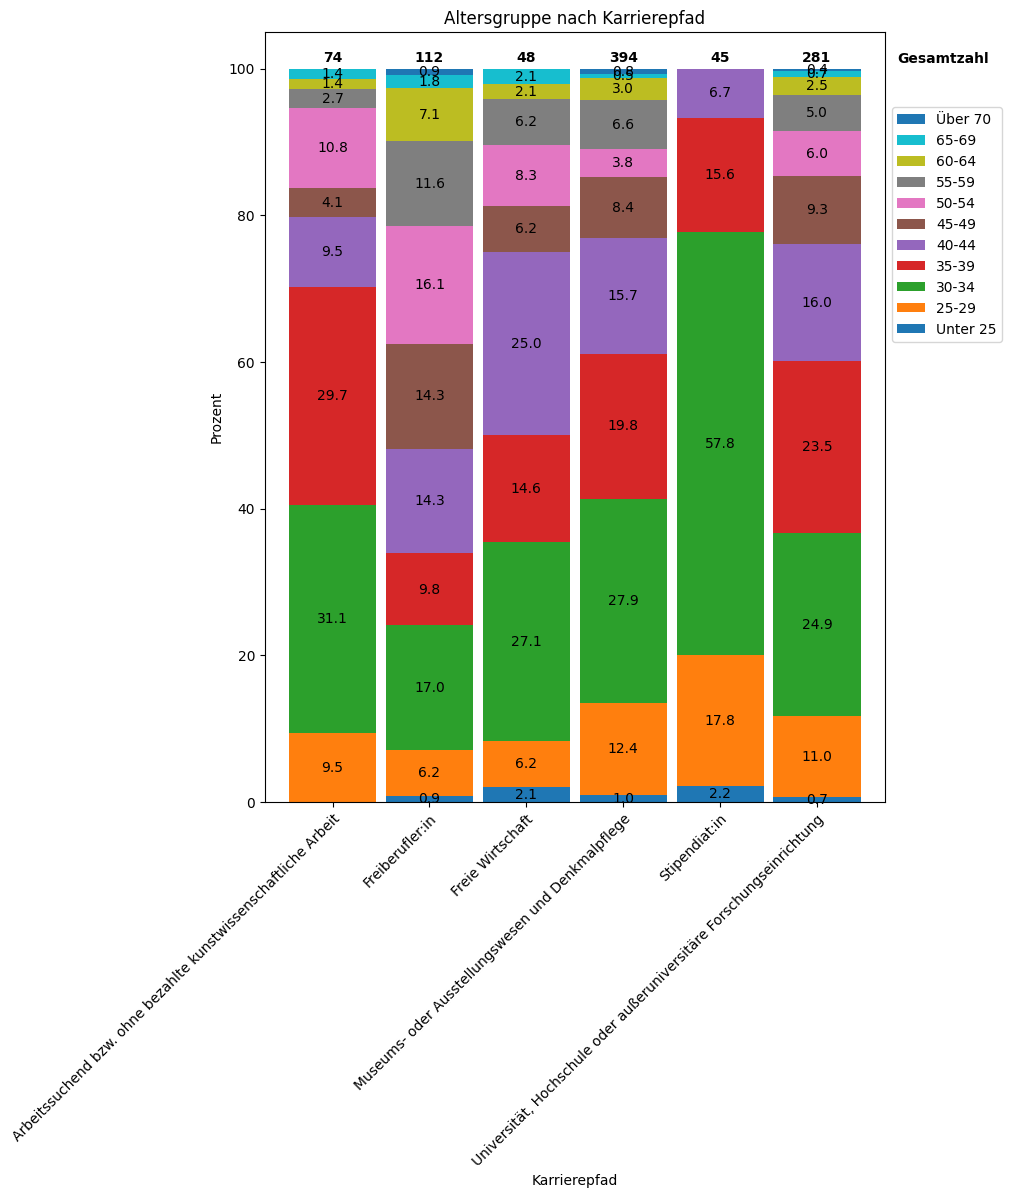

In [510]:
ax = car_age_df[car_age_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(8, 10),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Karrierepfad',
                        width=0.9,
                        title='Altersgruppe nach Karrierepfad'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(career, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(decoded_age_level)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(car_age_df['totals']):
    ax.text(car_age_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [511]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_04_Pfad_vs_Alter.png', bbox_inches='tight', dpi=300)

* Karrierepfad vs Geschlecht
* Karrierepfad vs Kinder

In [512]:
car_gender_df, car_gender_perc = cross_analysis_one_hot(ls_cols_career, ls_cols_gender)

Text(1.02, 0.975, 'Gesamtzahl')

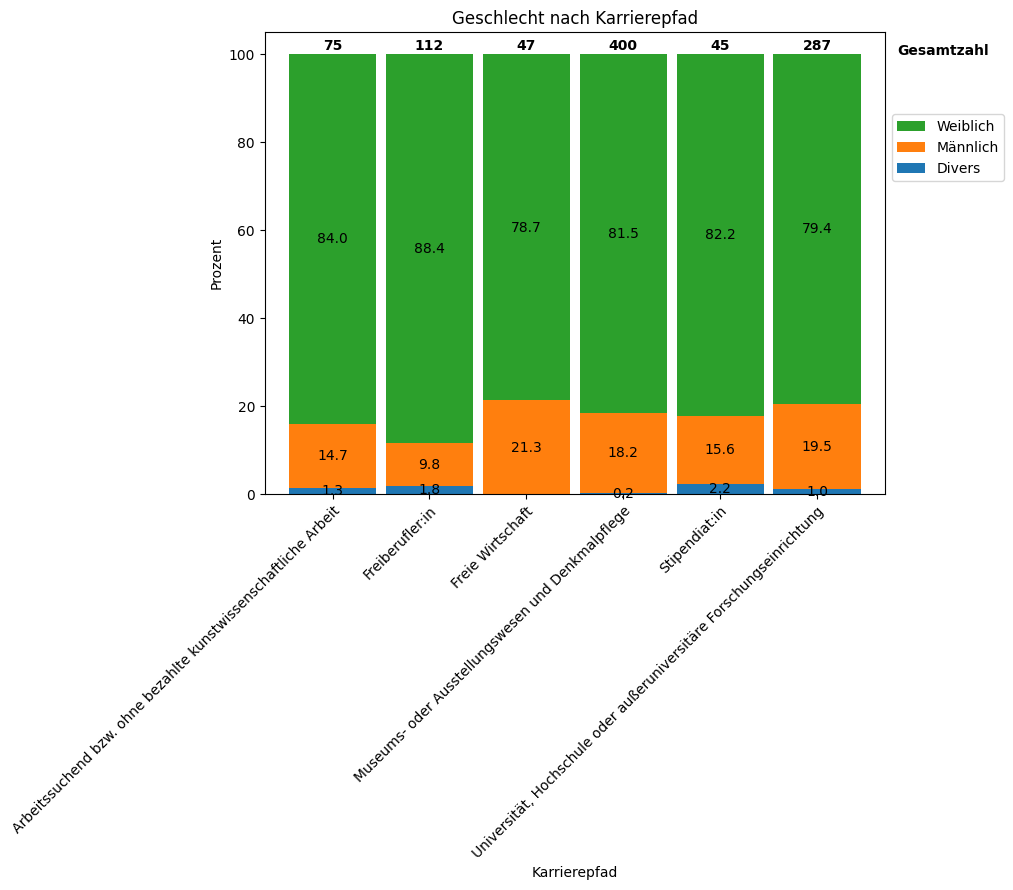

In [513]:
ax = car_gender_df[car_gender_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(8, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Karrierepfad',
                        width=0.9,
                        title='Geschlecht nach Karrierepfad'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(career, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(gender_levels)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(car_gender_df['totals']):
    ax.text(car_gender_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [514]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_05_Pfad_vs_Gender.png', bbox_inches='tight', dpi=300)

### Career vs having Childs

In [515]:
car_kids_df, car_kids_perc = cross_analysis_non_one_hot('CO2[SQ002]. Übernehmen Sie Betreuungsverantwortung? [Kind bzw. Kinder]', ls_cols_career, transpose=True)

In [516]:
car_kids_df

,CO2[SQ002]. Übernehmen Sie Betreuungsverantwortung? [Kind bzw. Kinder]_0_sum,CO2[SQ002]. Übernehmen Sie Betreuungsverantwortung? [Kind bzw. Kinder]_1_sum,totals,CO2[SQ002]. Übernehmen Sie Betreuungsverantwortung? [Kind bzw. Kinder]_0_sumPerc,CO2[SQ002]. Übernehmen Sie Betreuungsverantwortung? [Kind bzw. Kinder]_1_sumPerc
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",53,22,75,70.666667,29.333333
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",69,46,115,60.000000,40.000000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",33,15,48,68.750000,31.250000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",286,117,403,70.967742,29.032258
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",35,10,45,77.777778,22.222222
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",201,88,289,69.550173,30.449827


In [517]:
levels_children = ['keine Kinder', 'Kinder']

Text(1.02, 0.975, 'Gesamtzahl')

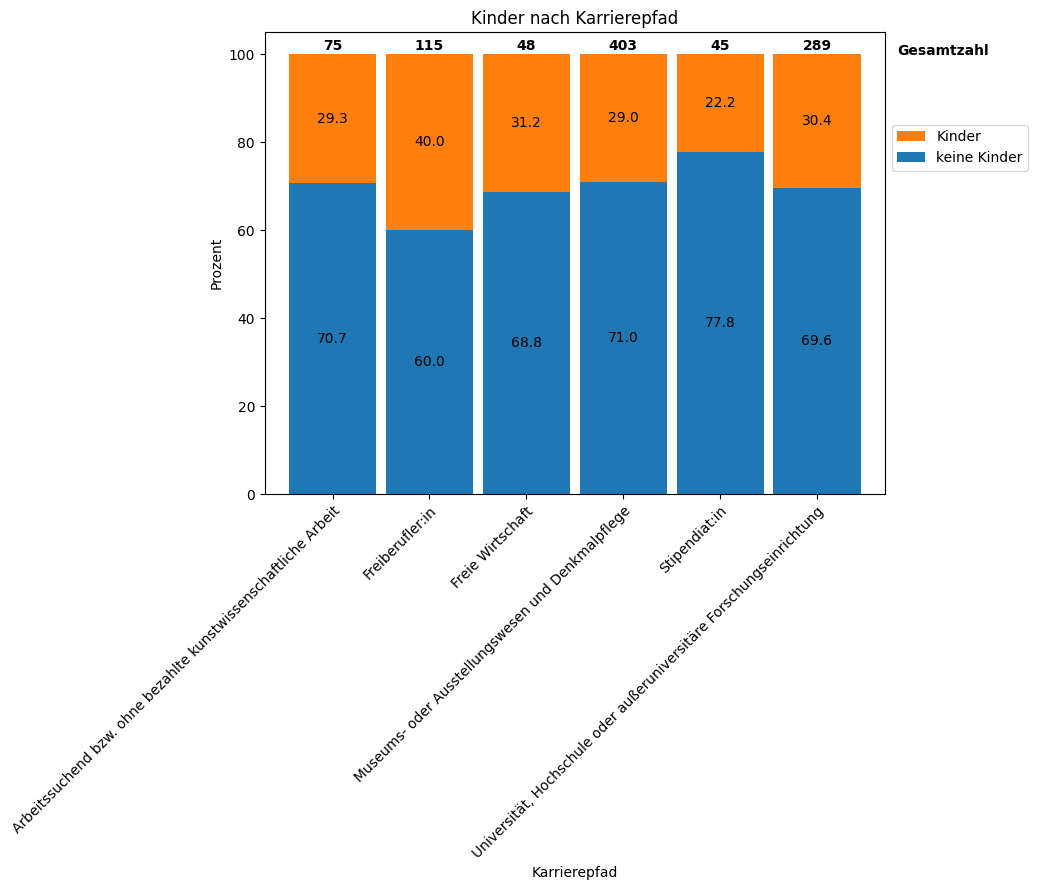

In [518]:
ax = car_kids_df[car_kids_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(8, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Karrierepfad',
                        width=0.9,
                        title='Kinder nach Karrierepfad'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(career, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(levels_children)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(car_kids_df['totals']):
    ax.text(car_kids_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [519]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_06_Pfad_vs_Kinder.png', bbox_inches='tight', dpi=300)

## random visualizations based on correlation analysis

### People out of job

In [520]:
ls_cols_career[0]

'AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0_Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit'

In [521]:
AS_career = ls_cols_career[0]

In [522]:
ls_qual_AS = [col for col in df_whole if col.startswith('AS7.')]
ls_qual_AS

['AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_Ja, mit einer höheren Qualifikation hätte ich entfristet werden können.',
 'AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_Nein, meine Qualifikation war nicht ausschlaggebend.',
 'AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_Sonstiges']

In [523]:
AS_qual_df, AS_qual_perc = cross_analysis_one_hot([AS_career], ls_qual_AS)
AS_qual_df

,"AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_Ja, mit einer höheren Qualifikation hätte ich entfristet werden können.","AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_Nein, meine Qualifikation war nicht ausschlaggebend.","AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_Sonstiges",totals,"AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_Ja, mit einer höheren Qualifikation hätte ich entfristet werden können.Percentage","AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_Nein, meine Qualifikation war nicht ausschlaggebend.Percentage","AS7. War der Qualifikationsgrad Grund dafür, dass Sie arbeitssuchend sind bzw. nicht weiterbeschäftigt werden konnten?_SonstigesPercentage"
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",2,58,4,64,3.125,90.625,6.25


In [524]:
levels_yes_no_other = ['Ja', 'Nein', 'Sonstiges']

Text(1.02, 0.975, 'Gesamtzahl')

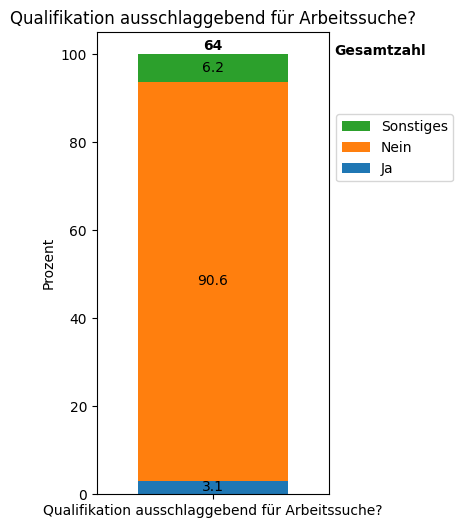

In [525]:
ax = AS_qual_df[AS_qual_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Qualifikation ausschlaggebend für Arbeitssuche?'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Qualifikation ausschlaggebend für Arbeitssuche?'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_yes_no_other)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(AS_qual_df['totals']):
    ax.text(AS_qual_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [526]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AS_00_Qualifikation_nicht_ausschlaggebend.png', bbox_inches='tight', dpi=300)

### Freelancer

In [527]:
ls_cols_career[1]

'AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0_Freiberufler:in'

In [528]:
F_career = ls_cols_career[1]
ls_small_business_F = [col for col in df_whole if col.startswith('F10.')]
ls_small_business_F

['F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_0',
 'F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_1',
 'F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_Sonstiges']

In [529]:
small_business_F_df, small_business_F_perc = cross_analysis_one_hot([F_career], ls_small_business_F)
small_business_F_df

,F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_0,F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_1,F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_Sonstiges,totals,F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_0Percentage,F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_1Percentage,F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_SonstigesPercentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",40,66,5,111,36.036036,59.459459,4.504505


In [530]:
levels_no_yes_other = ['Nein', 'Ja', 'Sonstiges']

Text(1.02, 0.975, 'Gesamtzahl')

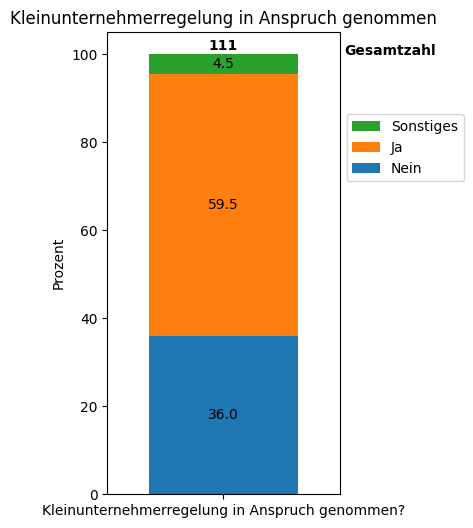

In [531]:
ax = small_business_F_df[small_business_F_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Kleinunternehmerregelung in Anspruch genommen'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Kleinunternehmerregelung in Anspruch genommen?'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_no_yes_other)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(small_business_F_df['totals']):
    ax.text(small_business_F_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [532]:
fig = ax.get_figure()
fig.savefig('../reports/figures/F_00_Kleinunternehmerregelung.png', bbox_inches='tight', dpi=300)

36% of all Freelancer report that they earned less than 22k € last year and will earn less than 50k € this year

In [533]:
ls_work_room_F = [col for col in df_whole if col.startswith('F2.')]
ls_work_room_F

['F2. Arbeitszimmer, Büro oder Geschäftsraum:_Außerhalb des Haushalts',
 'F2. Arbeitszimmer, Büro oder Geschäftsraum:_Innerhalb des Haushalts']

In [534]:
work_room_F_df,work_room_F_perc = cross_analysis_one_hot([F_career], ls_work_room_F)
work_room_F_df

,"F2. Arbeitszimmer, Büro oder Geschäftsraum:_Außerhalb des Haushalts","F2. Arbeitszimmer, Büro oder Geschäftsraum:_Innerhalb des Haushalts",totals,"F2. Arbeitszimmer, Büro oder Geschäftsraum:_Außerhalb des HaushaltsPercentage","F2. Arbeitszimmer, Büro oder Geschäftsraum:_Innerhalb des HaushaltsPercentage"
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",19,91,110,17.272727,82.727273


In [535]:
levels_work_room = ['Außerhalb des Haushalt', 'Innerhalb des Haushalt']

Text(1.02, 0.975, 'Gesamtzahl')

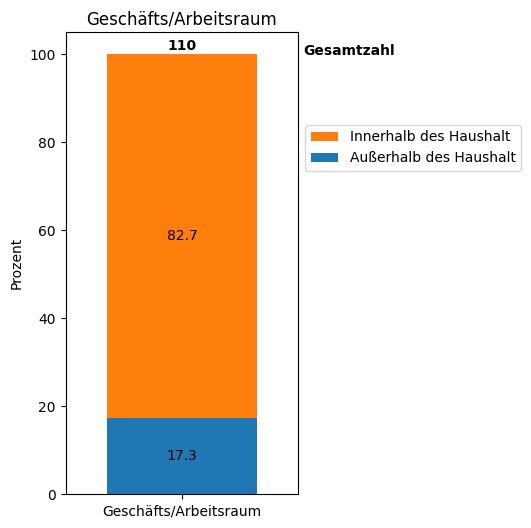

In [536]:
ax = work_room_F_df[work_room_F_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Geschäfts/Arbeitsraum'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Geschäfts/Arbeitsraum'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_work_room)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(work_room_F_df['totals']):
    ax.text(work_room_F_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [537]:
fig = ax.get_figure()
fig.savefig('../reports/figures/F_01_Arbeitsräume.png', bbox_inches='tight', dpi=300)

In [538]:
ls_security_F = [col for col in df_whole if col.startswith('F6.')]
ls_security_F

['F6. Wie sichern Sie sich finanziell, rechtlich und persönlich überwiegend ab?_Selbst',
 'F6. Wie sichern Sie sich finanziell, rechtlich und persönlich überwiegend ab?_Über andere (Mit- oder Vollfinanzierung)']

In [539]:
security_F_df, security_F_perc = cross_analysis_one_hot([F_career], ls_security_F)
security_F_df 

,"F6. Wie sichern Sie sich finanziell, rechtlich und persönlich überwiegend ab?_Selbst","F6. Wie sichern Sie sich finanziell, rechtlich und persönlich überwiegend ab?_Über andere (Mit- oder Vollfinanzierung)",totals,"F6. Wie sichern Sie sich finanziell, rechtlich und persönlich überwiegend ab?_SelbstPercentage","F6. Wie sichern Sie sich finanziell, rechtlich und persönlich überwiegend ab?_Über andere (Mit- oder Vollfinanzierung)Percentage"
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",84,25,109,77.06422,22.93578


In [540]:
levels_security = ['Selbst', 'Über andere']

Text(1.02, 0.975, 'Gesamtzahl')

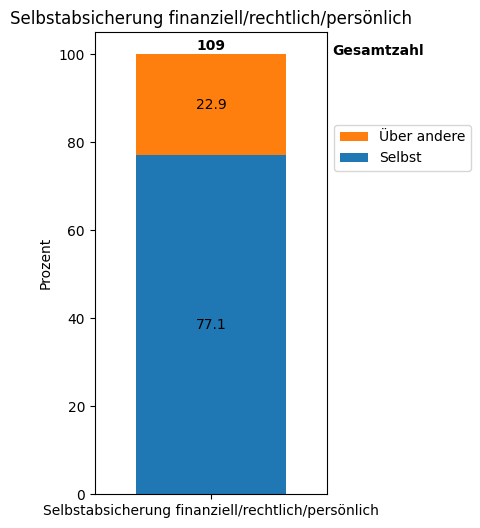

In [541]:
ax = security_F_df[security_F_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Selbstabsicherung finanziell/rechtlich/persönlich'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Selbstabsicherung finanziell/rechtlich/persönlich'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_security)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(security_F_df['totals']):
    ax.text(security_F_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [542]:
fig = ax.get_figure()
fig.savefig('../reports/figures/F_02_Absicherung.png', bbox_inches='tight', dpi=300)

### Freie Wirtschaft

In [543]:
W_career = ls_cols_career[2]
W_career

'AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0_Freie Wirtschaft'

In [544]:
ls_works_council_W = [col for col in df_whole if col.startswith('W15.')]
ls_works_council_W

['W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\xa0_Ja\u202f',
 'W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\xa0_Nein\u202f',
 'W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\xa0_Unbekannt']

In [545]:
works_council_W_df, works_council_W_perc = cross_analysis_one_hot([W_career], ls_works_council_W)
works_council_W_df

,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Ja,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Nein,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Unbekannt,totals,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Ja Percentage,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Nein Percentage,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _UnbekanntPercentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",15,30,2,47,31.914894,63.829787,4.255319


In [546]:
levels_yes_no_unknown = ['Ja', 'Nein', 'Unbekannt']

Text(1.02, 0.975, 'Gesamtzahl')

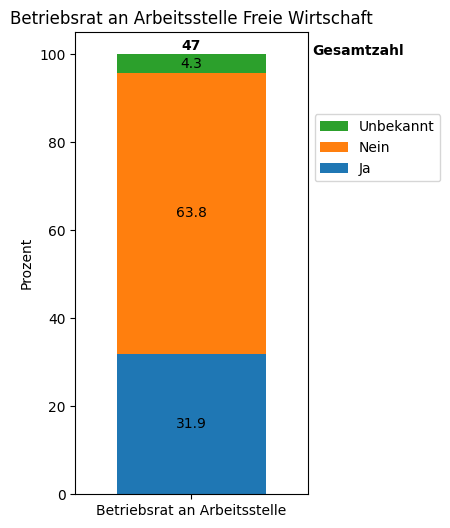

In [547]:
ax = works_council_W_df[works_council_W_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Betriebsrat an Arbeitsstelle Freie Wirtschaft'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Betriebsrat an Arbeitsstelle'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_yes_no_unknown)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(works_council_W_df['totals']):
    ax.text(works_council_W_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [548]:
fig = ax.get_figure()
fig.savefig('../reports/figures/W_00_Betriebsrat.png', bbox_inches='tight', dpi=300)

In [549]:
ls_diss_req_W = [col for col in df_whole if col.startswith('W5.')]
ls_diss_req_W

['W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_1',
 'W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_Nein, aber Promotion war gewünscht.',
 'W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_Nein, die Promotion war kein Einstellungskriterium.']

In [550]:
diss_req_W_df, diss_req_perc = cross_analysis_one_hot([W_career], ls_diss_req_W)
diss_req_W_df

,W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_1,"W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_Nein, aber Promotion war gewünscht.","W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_Nein, die Promotion war kein Einstellungskriterium.",totals,W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_1Percentage,"W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_Nein, aber Promotion war gewünscht.Percentage","W5. War eine Promotion Einstellungsvoraussetzung für Ihre derzeitige Stelle?_Nein, die Promotion war kein Einstellungskriterium.Percentage"
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",1,2,43,46,2.173913,4.347826,93.478261


In [551]:
levels_diss_needed = ['Ja', 'Nein - War aber gewünscht', 'Nein']

Text(1.02, 0.975, 'Gesamtzahl')

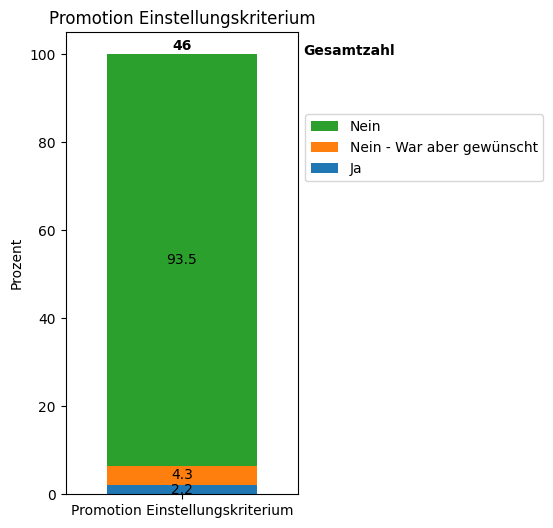

In [552]:
ax = diss_req_W_df[diss_req_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Promotion Einstellungskriterium'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Promotion Einstellungskriterium'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_diss_needed)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(diss_req_W_df['totals']):
    ax.text(diss_req_W_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [553]:
fig = ax.get_figure()
fig.savefig('../reports/figures/W_01_Promotion_Einstellungsvoraussetzung.png', bbox_inches='tight', dpi=300)

In [554]:
ls_tarif_salary_W = [col for col in df_whole if col.startswith('W6.')]
ls_tarif_salary_W

['W6. Werden Sie nach einem Tarifvertrag bezahlt?_0',
 'W6. Werden Sie nach einem Tarifvertrag bezahlt?_1',
 'W6. Werden Sie nach einem Tarifvertrag bezahlt?_Sonstiges']

In [555]:
tarif_salary_W_df, tarif_salary_W_perc = cross_analysis_one_hot([W_career], ls_tarif_salary_W)
tarif_salary_W_df

,W6. Werden Sie nach einem Tarifvertrag bezahlt?_0,W6. Werden Sie nach einem Tarifvertrag bezahlt?_1,W6. Werden Sie nach einem Tarifvertrag bezahlt?_Sonstiges,totals,W6. Werden Sie nach einem Tarifvertrag bezahlt?_0Percentage,W6. Werden Sie nach einem Tarifvertrag bezahlt?_1Percentage,W6. Werden Sie nach einem Tarifvertrag bezahlt?_SonstigesPercentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",32,5,9,46,69.565217,10.869565,19.565217


Text(1.02, 0.975, 'Gesamtzahl')

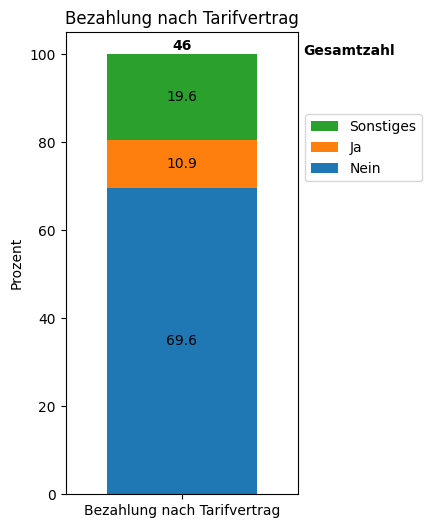

In [556]:
ax = tarif_salary_W_df[tarif_salary_W_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Bezahlung nach Tarifvertrag'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Bezahlung nach Tarifvertrag'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_no_yes_other)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(tarif_salary_W_df['totals']):
    ax.text(tarif_salary_W_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [557]:
fig = ax.get_figure()
fig.savefig('../reports/figures/W_02_Bezahlung_Tarifvertrag.png', bbox_inches='tight', dpi=300)

### Museum

In [558]:
M_career = ls_cols_career[3]
M_career

'AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0_Museums- oder Ausstellungswesen und Denkmalpflege'

In [559]:
ls_works_council_M = [col for col in df_whole if col.startswith('M11.')]
ls_works_council_M

['M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\u202f_Ja\u202f',
 'M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\u202f_Nein\u202f',
 'M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\u202f_Unbekannt']

In [560]:
works_council_M_df, works_council_M_perc = cross_analysis_one_hot([M_career], ls_works_council_M)
works_council_M_df

,M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Ja,M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Nein,M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Unbekannt,totals,M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Ja Percentage,M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Nein Percentage,M11. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _UnbekanntPercentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",274,102,21,397,69.017632,25.692695,5.289673


Text(1.02, 0.975, 'Gesamtzahl')

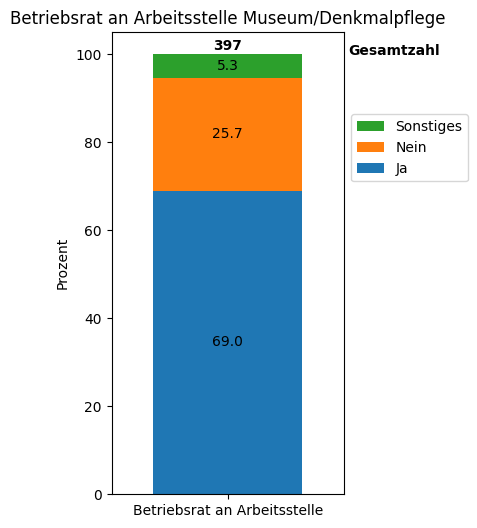

In [561]:
ax = works_council_M_df[works_council_M_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Betriebsrat an Arbeitsstelle Museum/Denkmalpflege'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Betriebsrat an Arbeitsstelle'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_yes_no_other)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(works_council_M_df['totals']):
    ax.text(works_council_M_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [562]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_05_Betriebsrat.png', bbox_inches='tight', dpi=300)

In [563]:
name = df_whole.columns.to_list()
# open file in write mode
with open(r'../data/interim/col_names_df_whole.txt', 'w') as fp:
    for item in name:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


## comparison stipend holders for dissertation and doctoral researchers at universities

### combine data of stipendholders and doctoral researchers in university

Problem: There is no easy way to filter for doctoral researchers at universities. As an assumption I am defining those participants as doctoral researchers that have gotten their Bachelors, Masters, Diploma, Staatsexamen recently, are in a Qualifikationsphase and are working at a university.

In [564]:
UH_career = ls_cols_career[5]

In [565]:
DR_UH_df = df_whole[((df_whole['AP2[SQ002]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Master of Arts:]']==1) |
                     (df_whole['AP2[SQ003]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Magister Artium:]']) |
                     (df_whole['AP2[SQ004]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [I. Staatsexamen:]']) |
                     (df_whole['AP2[SQ005]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [II. Staatsexamen:]']) |
                     (df_whole['AP2[SQ006]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Diplom:]']) | 
                     (df_whole['AP2[SQ001]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Bachelor of Arts: ]'])) 
                    & 
                    (df_whole['AP3. Befinden Sie sich derzeit in einer Qualifikationsphase?']==1) & 
                    (df_whole['AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0_Universität, Hochschule oder außeruniversitäre Forschungseinrichtung']==True)]

In [566]:
DR_UH_df.shape

(122, 836)

In [567]:
ls_col_position_UH = [col for col in df_whole.columns if col.startswith('UH1.')]

In [568]:
temp_df, temp_perc = cross_analysis_one_hot([UH_career], ls_col_position_UH, df=DR_UH_df)

In [569]:
temp_df

,UH1. Wie lautet die Bezeichnung für Ihre Position?_Akademische:r Oberrat bzw. -rätin,UH1. Wie lautet die Bezeichnung für Ihre Position?_Akademische:r Rat bzw. Rätin,UH1. Wie lautet die Bezeichnung für Ihre Position?_Assistent:in,UH1. Wie lautet die Bezeichnung für Ihre Position?_Außerplanmäßige oder -ordentliche Professor:in,UH1. Wie lautet die Bezeichnung für Ihre Position?_Juniorprofessor:in,UH1. Wie lautet die Bezeichnung für Ihre Position?_Kurator:in bzw. Kustod:in,UH1. Wie lautet die Bezeichnung für Ihre Position?_Lehrkraft für besondere Aufgaben,UH1. Wie lautet die Bezeichnung für Ihre Position?_Privatdozent:in,UH1. Wie lautet die Bezeichnung für Ihre Position?_Professor:in auf Zeit- oder Tenure-Track-Basis,UH1. Wie lautet die Bezeichnung für Ihre Position?_Sonstiges,...,UH1. Wie lautet die Bezeichnung für Ihre Position?_Kurator:in bzw. Kustod:inPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Lehrkraft für besondere AufgabenPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Privatdozent:inPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Professor:in auf Zeit- oder Tenure-Track-BasisPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_SonstigesPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Volontär:inPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche Hilfskraft (mit MA)Percentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:inPercentage,"UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in in einem Graduiertenkolleg, SFB oder DrittmittelprojektPercentage",UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in mit KoordinationsaufgabenPercentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",0,1,5,0,1,0,1,0,1,13,...,0.0,0.819672,0.0,0.819672,10.655738,0.0,7.377049,44.262295,23.770492,6.557377


In [570]:
# remove those columns that have have only zeroes
temp_df = temp_df.loc[:, (temp_df != 0).any(axis=0)]
temp_df

,UH1. Wie lautet die Bezeichnung für Ihre Position?_Akademische:r Rat bzw. Rätin,UH1. Wie lautet die Bezeichnung für Ihre Position?_Assistent:in,UH1. Wie lautet die Bezeichnung für Ihre Position?_Juniorprofessor:in,UH1. Wie lautet die Bezeichnung für Ihre Position?_Lehrkraft für besondere Aufgaben,UH1. Wie lautet die Bezeichnung für Ihre Position?_Professor:in auf Zeit- oder Tenure-Track-Basis,UH1. Wie lautet die Bezeichnung für Ihre Position?_Sonstiges,UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche Hilfskraft (mit MA),UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in,"UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in in einem Graduiertenkolleg, SFB oder Drittmittelprojekt",UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in mit Koordinationsaufgaben,...,UH1. Wie lautet die Bezeichnung für Ihre Position?_Akademische:r Rat bzw. RätinPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Assistent:inPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Juniorprofessor:inPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Lehrkraft für besondere AufgabenPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Professor:in auf Zeit- oder Tenure-Track-BasisPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_SonstigesPercentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche Hilfskraft (mit MA)Percentage,UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:inPercentage,"UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in in einem Graduiertenkolleg, SFB oder DrittmittelprojektPercentage",UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in mit KoordinationsaufgabenPercentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",1,5,1,1,1,13,9,54,29,8,...,0.819672,4.098361,0.819672,0.819672,0.819672,10.655738,7.377049,44.262295,23.770492,6.557377


In [571]:
temp_perc = [item for item in temp_df.columns.tolist() if item.endswith('Percentage')]
temp_perc

['UH1. Wie lautet die Bezeichnung für Ihre Position?_Akademische:r Rat bzw. RätinPercentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_Assistent:inPercentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_Juniorprofessor:inPercentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_Lehrkraft für besondere AufgabenPercentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_Professor:in auf Zeit- oder Tenure-Track-BasisPercentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_SonstigesPercentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche Hilfskraft (mit MA)Percentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:inPercentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in in einem Graduiertenkolleg, SFB oder DrittmittelprojektPercentage',
 'UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche:r Mitarbeiter:in mit Koordina

In [572]:
ls_exclude = [col for col in temp_df if (col.endswith('Percentage')) | (col == 'totals')]
# get a list of university positions by first filtering out the unwanted column names and use only the string after _
ls_position_levels_DR_UH = [item.split(sep='_')[-1] for item in temp_df.columns.to_list() if item not in ls_exclude]

Text(1.02, 0.975, 'Gesamtzahl')

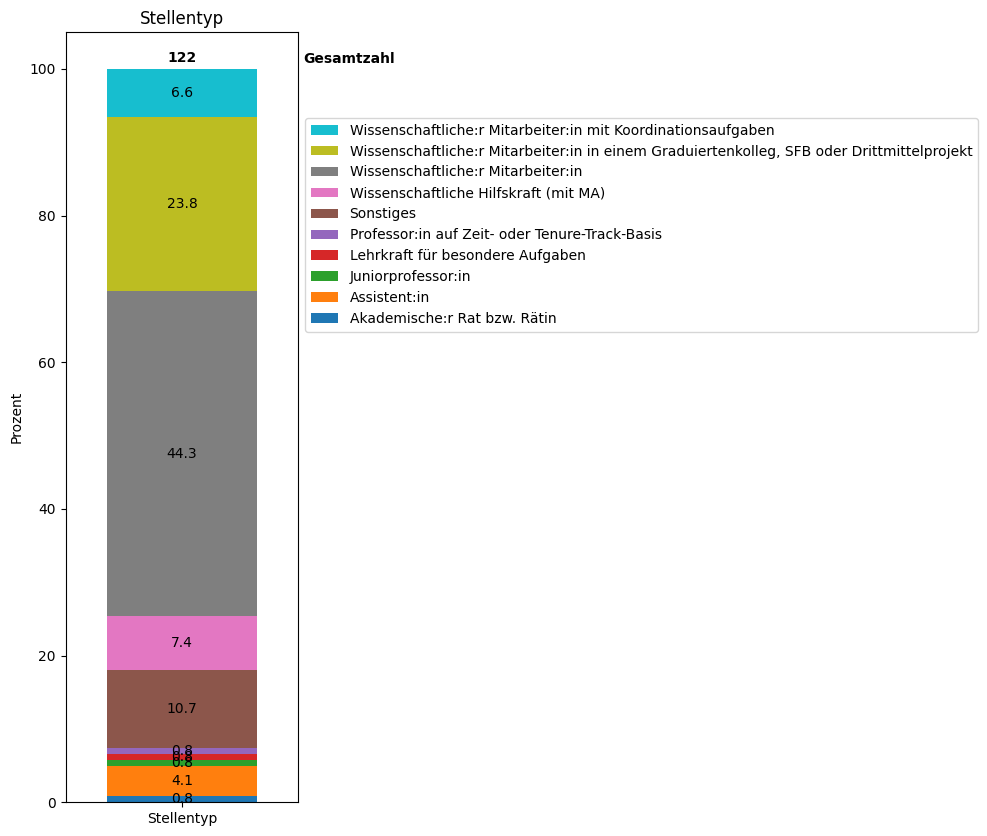

In [573]:
ax = temp_df[temp_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 10),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Stellentyp'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Stellentyp'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(ls_position_levels_DR_UH)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(temp_df['totals']):
    ax.text(temp_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [574]:
fig = ax.get_figure()
fig.savefig('../reports/figures/UH_00_Stellentyp_Master_auf_Qualifikationsstelle.png', bbox_inches='tight', dpi=300)

Decision has to be made on whether to exclude Assistent:innen, Wissenschaftliche Hilfskräfte and Sonstige to be sure to have a pure Doctoral Researcher population.

In [575]:
# remove all entries that describe their position as Sonstiges, except if their LimeSurvey ID is 1517, 5, 557. Those reported themselves as Doktorand
DR_UH_df = DR_UH_df[~((DR_UH_df['UH1. Wie lautet die Bezeichnung für Ihre Position?_Sonstiges']) & ~(DR_UH_df['id. Antwort ID'].isin([1517, 5, 557])))]

In [576]:
DR_UH_df[DR_UH_df['UH1. Wie lautet die Bezeichnung für Ihre Position?_Sonstiges']]

,AP1. Wie alt sind Sie?,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_10.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,...,W7[SQ004]. Welche Form von Vergütung erhalten Sie? [Weihnachtsgeld],W7[SQ005]. Welche Form von Vergütung erhalten Sie? [Urlaubsgeld],W7[SQ006]. Welche Form von Vergütung erhalten Sie? [Sachwerte],W8[SQ001]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Arbeitszeitausgleich],W8[SQ002]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Bezahlung],W8[SQ003]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Sachwerte],W8[SQ004]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Gar nicht],W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_1,W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_Teils,id. Antwort ID
132,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,5
519,3.0,False,False,False,False,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1517
568,3.0,False,False,False,False,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,557


In [577]:
# Remove those entries, that do not fit Doctoral Researcher positions
columns_to_check = ['UH1. Wie lautet die Bezeichnung für Ihre Position?_Akademische:r Rat bzw. Rätin',
                    'UH1. Wie lautet die Bezeichnung für Ihre Position?_Assistent:in',
                    'UH1. Wie lautet die Bezeichnung für Ihre Position?_Juniorprofessor:in',
                    'UH1. Wie lautet die Bezeichnung für Ihre Position?_Lehrkraft für besondere Aufgaben',
                    'UH1. Wie lautet die Bezeichnung für Ihre Position?_Professor:in auf Zeit- oder Tenure-Track-Basis',
                    'UH1. Wie lautet die Bezeichnung für Ihre Position?_Wissenschaftliche Hilfskraft (mit MA)']
DR_UH_df = DR_UH_df[~DR_UH_df[columns_to_check].any(axis=1)]

check if filtering worked.

Text(1.02, 0.975, 'Gesamtzahl')

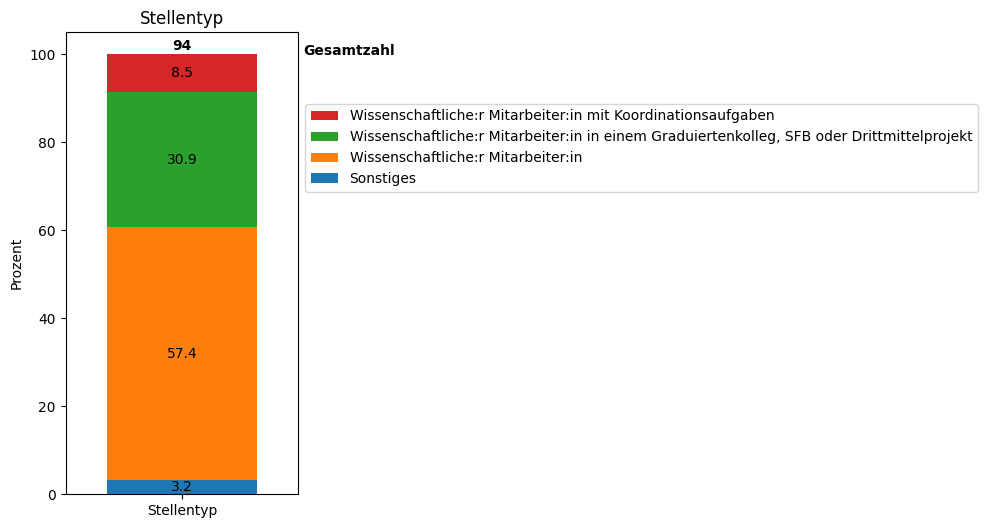

In [578]:
temp_df, temp_perc = cross_analysis_one_hot([UH_career], ls_col_position_UH, df=DR_UH_df)
# remove those columns that have have only zeroes
temp_df = temp_df.loc[:, (temp_df != 0).any(axis=0)]
temp_perc = [item for item in temp_df.columns.tolist() if item.endswith('Percentage')]
ls_exclude = [col for col in temp_df if (col.endswith('Percentage')) | (col == 'totals')]
# get a list of university positions by first filtering out the unwanted column names and use only the string after _
ls_position_levels_DR_UH = [item.split(sep='_')[-1] for item in temp_df.columns.to_list() if item not in ls_exclude]

ax = temp_df[temp_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Stellentyp'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Stellentyp'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(ls_position_levels_DR_UH)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(temp_df['totals']):
    ax.text(temp_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [579]:
fig = ax.get_figure()
fig.savefig('../reports/figures/UH_00_Stellentyp_Master_auf_Qualifikationsstelle.png', bbox_inches='tight', dpi=300)

In [580]:
# Create DataFrame with stipendholders that are doing a PhD
DR_stipend_df = df_whole[df_whole['S1[SQ004]. Zu welchem Zweck beziehen Sie ein Stipendium? [Promotions-Projekt]']==True]
print(DR_stipend_df.shape)
print(DR_UH_df.shape)

(38, 836)
(94, 836)


In [581]:
# combine stipend and university DataFrames and exclude unnecessary columns
DR_df = pd.concat([DR_UH_df, DR_stipend_df])
cols_to_keep = [col for col in DR_df.columns if col.startswith(('AP', 'CO', 'S', 'UH'))]
DR_df = DR_df[cols_to_keep]
DR_df

,AP1. Wie alt sind Sie?,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_10.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,...,UH8. In welchem Bundesland sind Sie tätig?_Nordrhein-Westfalen,UH8. In welchem Bundesland sind Sie tätig?_Rheinland-Pfalz,UH8. In welchem Bundesland sind Sie tätig?_Saarland,UH8. In welchem Bundesland sind Sie tätig?_Sachsen,UH8. In welchem Bundesland sind Sie tätig?_Sachsen-Anhalt,UH8. In welchem Bundesland sind Sie tätig?_Schleswig-Holstein,UH8. In welchem Bundesland sind Sie tätig?_Thüringen,"UH9. Sind Ihre Tätigkeiten dieselben, wie vertraglich vereinbart? _0","UH9. Sind Ihre Tätigkeiten dieselben, wie vertraglich vereinbart? _1","UH9. Sind Ihre Tätigkeiten dieselben, wie vertraglich vereinbart? _Teils"
4,2.0,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
6,2.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,2.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9,2.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
12,1.0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,2.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
905,2.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
935,1.0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1001,2.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [582]:
DR_df.to_csv('../data/processed/04_doctoral_researchers.csv')

### data visualization

In [583]:
S_career = ls_cols_career[4]

In [584]:
DR_df[S_career].sum()

38

In [585]:
data_dict = {
    'stipend' : [DR_df[S_career].sum()],
    'university' : [DR_df[UH_career].sum()],
    'totals' : [DR_df[S_career].sum() + DR_df[UH_career].sum()],
    'stipendPerc' : [DR_df[S_career].sum() / (DR_df[S_career].sum() + DR_df[UH_career].sum()) * 100],
    'universityPerc' : [DR_df[UH_career].sum() / (DR_df[S_career].sum() + DR_df[UH_career].sum()) * 100]
    
}
S_vs_UH_df = pd.DataFrame(data_dict)

In [586]:
S_vs_UH_df

,stipend,university,totals,stipendPerc,universityPerc
0,38,94,132,28.787879,71.212121


In [587]:
levels_stipend_university = ['Stipendium', 'Stelle an Hochschule']

Text(1.02, 0.975, 'Gesamtzahl')

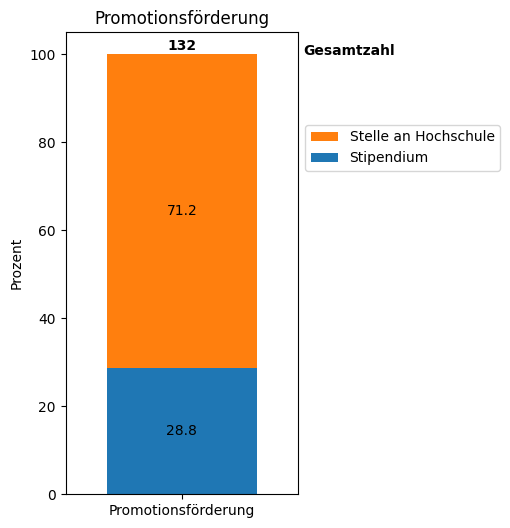

In [588]:
ax = S_vs_UH_df[['stipendPerc', 'universityPerc']].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Promotionsförderung'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Promotionsförderung'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_stipend_university)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(S_vs_UH_df['totals']):
    ax.text(S_vs_UH_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [589]:
fig = ax.get_figure()
fig.savefig('../reports/figures/DR_00_Promotionsförderung.png', bbox_inches='tight', dpi=300)

In [590]:
ls_health_insurance_S = [col for col in DR_df if col.startswith('S8r')]

In [591]:
ls_health_insurance_S

['S8r. Wenn ja, worüber?_Familienversicherung',
 'S8r. Wenn ja, worüber?_Freiwillige gesetzliche Krankenversicherung',
 'S8r. Wenn ja, worüber?_Sonstiges',
 'S8r. Wenn ja, worüber?_Studierende:r in einer gesetzlichen Krankenversicherung']

In [592]:
health_insurance_S_df, health_insurance_S_perc = cross_analysis_one_hot([S_career], ls_health_insurance_S, df=DR_df)
ls_health_insurance_levels = [item]

In [593]:
health_insurance_S_df

,"S8r. Wenn ja, worüber?_Familienversicherung","S8r. Wenn ja, worüber?_Freiwillige gesetzliche Krankenversicherung","S8r. Wenn ja, worüber?_Sonstiges","S8r. Wenn ja, worüber?_Studierende:r in einer gesetzlichen Krankenversicherung",totals,"S8r. Wenn ja, worüber?_FamilienversicherungPercentage","S8r. Wenn ja, worüber?_Freiwillige gesetzliche KrankenversicherungPercentage","S8r. Wenn ja, worüber?_SonstigesPercentage","S8r. Wenn ja, worüber?_Studierende:r in einer gesetzlichen KrankenversicherungPercentage"
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",12,17,4,3,36,33.333333,47.222222,11.111111,8.333333


In [594]:
ls_exclude = [col for col in health_insurance_S_df.columns if (col.endswith('Percentage')) | (col == 'totals')]
# get a list of university positions by first filtering out the unwanted column names and use only the string after _
ls_health_insurance_levels = [item.split(sep='_')[-1] for item in health_insurance_S_df.columns.to_list() if item not in ls_exclude]

In [595]:
ls_health_insurance_levels

['Familienversicherung',
 'Freiwillige gesetzliche Krankenversicherung',
 'Sonstiges',
 'Studierende:r in einer gesetzlichen Krankenversicherung']

Text(1.02, 0.975, 'Gesamtzahl')

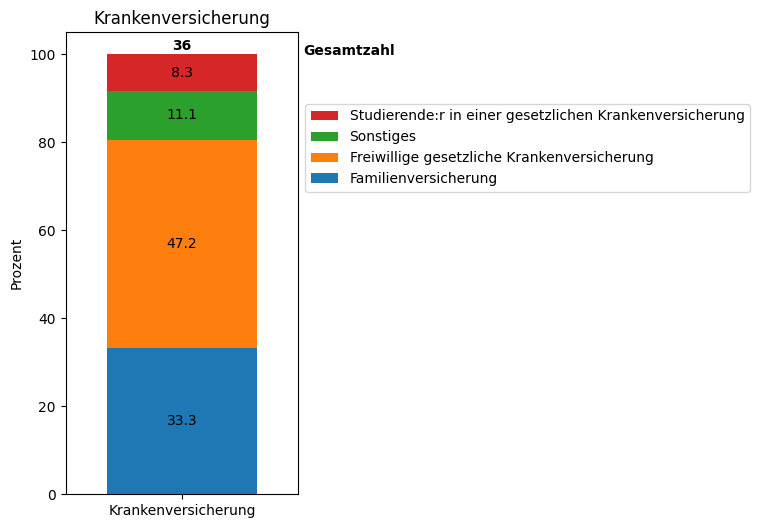

In [596]:
ax = health_insurance_S_df[health_insurance_S_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(3, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        #xlabel='Karrierepfad',
                        width=0.9,
                        title='Krankenversicherung'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Krankenversicherung'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(ls_health_insurance_levels)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(health_insurance_S_df['totals']):
    ax.text(health_insurance_S_df['totals'].reset_index().index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [597]:
fig = ax.get_figure()
fig.savefig('../reports/figures/DR_01_Krankenversicherung_Stips.png', bbox_inches='tight', dpi=300)

In [598]:
pension_S_df, pension_S_perc = cross_analysis_non_one_hot('S9. Betreiben Sie Altersvorsorge?', ls_cols_age_level, df=DR_df, transpose=True)
pension_S_df

,S9. Betreiben Sie Altersvorsorge?_0.0_sum,S9. Betreiben Sie Altersvorsorge?_1.0_sum,totals,S9. Betreiben Sie Altersvorsorge?_0.0_sumPerc,S9. Betreiben Sie Altersvorsorge?_1.0_sumPerc
AP1. Wie alt sind Sie?_0.0,0.0,0.0,0.0,0.000000,0.000000
AP1. Wie alt sind Sie?_1.0,5.0,3.0,8.0,62.500000,37.500000
AP1. Wie alt sind Sie?_2.0,17.0,6.0,23.0,73.913043,26.086957
AP1. Wie alt sind Sie?_3.0,4.0,0.0,4.0,100.000000,0.000000
AP1. Wie alt sind Sie?_4.0,1.0,0.0,1.0,100.000000,0.000000
AP1. Wie alt sind Sie?_5.0,0.0,0.0,0.0,0.000000,0.000000
AP1. Wie alt sind Sie?_6.0,0.0,0.0,0.0,0.000000,0.000000
AP1. Wie alt sind Sie?_7.0,0.0,0.0,0.0,0.000000,0.000000
AP1. Wie alt sind Sie?_8.0,0.0,0.0,0.0,0.000000,0.000000
AP1. Wie alt sind Sie?_9.0,0.0,0.0,0.0,0.000000,0.000000


In [599]:
pension_S_df = pension_S_df[~(pension_S_df == 0).all(axis=1)]

In [600]:
pension_S_df

,S9. Betreiben Sie Altersvorsorge?_0.0_sum,S9. Betreiben Sie Altersvorsorge?_1.0_sum,totals,S9. Betreiben Sie Altersvorsorge?_0.0_sumPerc,S9. Betreiben Sie Altersvorsorge?_1.0_sumPerc
AP1. Wie alt sind Sie?_1.0,5.0,3.0,8.0,62.500000,37.500000
AP1. Wie alt sind Sie?_2.0,17.0,6.0,23.0,73.913043,26.086957
AP1. Wie alt sind Sie?_3.0,4.0,0.0,4.0,100.000000,0.000000
AP1. Wie alt sind Sie?_4.0,1.0,0.0,1.0,100.000000,0.000000


In [601]:
levels_no_yes = ['Nein', 'Ja']

Text(1.02, 0.975, 'Gesamtzahl')

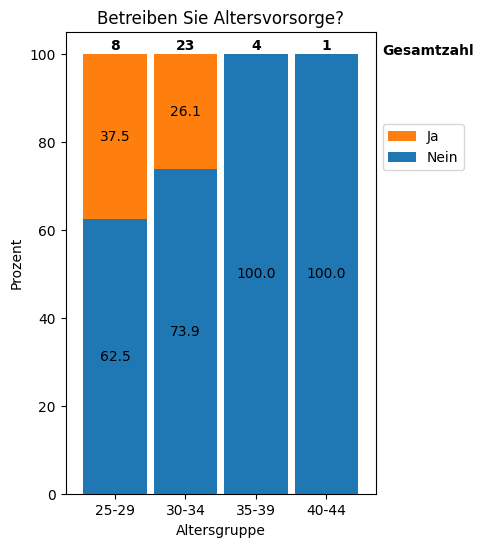

In [602]:
ax = pension_S_df[pension_S_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(4, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Altersgruppe',
                        width=0.9,
                        title='Betreiben Sie Altersvorsorge?'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['25-29', '30-34', '35-39', '40-44'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_no_yes)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(pension_S_df['totals']):
    ax.text(pension_S_df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [603]:
fig = ax.get_figure()
fig.savefig('../reports/figures/DR_02_Altersvorsorge_Stips.png', bbox_inches='tight', dpi=300)

#### expectation after end of position

##### harmonisation of columns

In [604]:
ls_cols_expec_after_UH = [col for col in DR_df.columns if col.startswith('UH24')]
ls_cols_expec_after_S = [col for col in DR_df.columns if col.startswith('S22')]

In [605]:
ls_cols_expec_after_UH

['UH24[SQ001]. Was erwartet Sie nach dem Ablauf Ihres derzeitigen Arbeitsvertrages? [Entfristung der derzeitigen Stelle ]',
 'UH24[SQ002]. Was erwartet Sie nach dem Ablauf Ihres derzeitigen Arbeitsvertrages? [Verlängerung der derzeitigen Stelle]',
 'UH24[SQ003]. Was erwartet Sie nach dem Ablauf Ihres derzeitigen Arbeitsvertrages? [Stelle bzw. Projekt gesichert]',
 'UH24[SQ004]. Was erwartet Sie nach dem Ablauf Ihres derzeitigen Arbeitsvertrages? [Abschluss des Forschungsvorhabens bzw. meiner Qualifikationsarbeit erst nach Ende des Vertrages]',
 'UH24[SQ005]. Was erwartet Sie nach dem Ablauf Ihres derzeitigen Arbeitsvertrages? [Abbruch des betreffenden Forschungsvorhabens]',
 'UH24[SQ006]. Was erwartet Sie nach dem Ablauf Ihres derzeitigen Arbeitsvertrages? [Antrags- bzw. Bewerbungsphase]',
 'UH24[SQ007]. Was erwartet Sie nach dem Ablauf Ihres derzeitigen Arbeitsvertrages? [Hoffnung auf eine Stelle oder eine Anschlussprojekt]',
 'UH24[SQ008]. Was erwartet Sie nach dem Ablauf Ihres derze

In [606]:
ls_cols_expec_after_S

['S22[SQ001]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Antrags- bzw. Bewerbungsphase]',
 'S22[SQ002]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Hoffnung auf Arbeit oder Anschlussprojekt ]',
 'S22[SQ003]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Stelle bzw. Projekt gesichert]',
 'S22[SQ004]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Abschluss des Forschungsvorhabens nach der Förderzeit ]',
 'S22[SQ005]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Antrag auf Abschlussstipendium ]',
 'S22[SQ006]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Restanspruch auf ALG I ]',
 'S22[SQ007]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Antrag auf ALG II (Hartz IV) ]',
 'S22[SQ008]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Mutterschutz bzw. Elternzeit ]',
 'S22[SQ009]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Berufliche Umorientierung]',
 'S22[SQ010]. Was erwartet Sie nach dem Ablauf des S

In [607]:
ls_cols_expec_after_UH_extract = [extract_last_bracket(col) for col in ls_cols_expec_after_UH]
ls_cols_expec_after_S_extract = [extract_last_bracket(col) for col in ls_cols_expec_after_S]

In [608]:
ls_cols_expec_after_UH_extract

['Entfristung der derzeitigen Stelle',
 'Verlängerung der derzeitigen Stelle',
 'Stelle bzw. Projekt gesichert',
 'Abschluss des Forschungsvorhabens bzw. meiner Qualifikationsarbeit erst nach Ende des Vertrages',
 'Abbruch des betreffenden Forschungsvorhabens',
 'Antrags- bzw. Bewerbungsphase',
 'Hoffnung auf eine Stelle oder eine Anschlussprojekt',
 'Mutterschutz bzw. Elternzeit',
 'Berufliche Umorientierung',
 'Anspruch auf ALG I',
 'Antrag auf ALG II (Hartz IV)']

In [609]:
ls_cols_expec_after_S_extract

['Antrags- bzw. Bewerbungsphase',
 'Hoffnung auf Arbeit oder Anschlussprojekt',
 'Stelle bzw. Projekt gesichert',
 'Abschluss des Forschungsvorhabens nach der Förderzeit',
 'Antrag auf Abschlussstipendium',
 'Restanspruch auf ALG I',
 'Antrag auf ALG II (Hartz IV)',
 'Mutterschutz bzw. Elternzeit',
 'Berufliche Umorientierung',
 'Abbruch des betreffenden Forschungsvorhabens']

In [610]:
# Lists of old and new entries
old_entries = [
    'Abschluss des Forschungsvorhabens bzw. meiner Qualifikationsarbeit erst nach Ende des Vertrages',
    'Hoffnung auf eine Stelle oder eine Anschlussprojekt',
    'Restanspruch auf ALG I'
]
new_entries = [
    'Abschluss des Forschungsvorhabens nach der Förderzeit',
    'Hoffnung auf Arbeit oder Anschlussprojekt',
    'Anspruch auf ALG I'
]

# Create a mapping dictionary from old entries to new entries
replacement_map = dict(zip(old_entries, new_entries))

# Modify the list using the mapping
ls_cols_expec_after_UH_extract = [replacement_map.get(item, item) for item in ls_cols_expec_after_UH_extract]

print(ls_cols_expec_after_UH_extract)

['Entfristung der derzeitigen Stelle', 'Verlängerung der derzeitigen Stelle', 'Stelle bzw. Projekt gesichert', 'Abschluss des Forschungsvorhabens nach der Förderzeit', 'Abbruch des betreffenden Forschungsvorhabens', 'Antrags- bzw. Bewerbungsphase', 'Hoffnung auf Arbeit oder Anschlussprojekt', 'Mutterschutz bzw. Elternzeit', 'Berufliche Umorientierung', 'Anspruch auf ALG I', 'Antrag auf ALG II (Hartz IV)']


In [611]:
# Lists of old and new entries
old_entries = [
    'Abschluss des Forschungsvorhabens bzw. meiner Qualifikationsarbeit erst nach Ende des Vertrages',
    'Hoffnung auf eine Stelle oder eine Anschlussprojekt',
    'Restanspruch auf ALG I'
]
new_entries = [
    'Abschluss des Forschungsvorhabens nach der Förderzeit',
    'Hoffnung auf Arbeit oder Anschlussprojekt',
    'Anspruch auf ALG I'
]

# Create a mapping dictionary from old entries to new entries
replacement_map = dict(zip(old_entries, new_entries))

# Modify the list using the mapping
ls_cols_expec_after_S_extract = [replacement_map.get(item, item) for item in ls_cols_expec_after_S_extract]

print(ls_cols_expec_after_S_extract)

['Antrags- bzw. Bewerbungsphase', 'Hoffnung auf Arbeit oder Anschlussprojekt', 'Stelle bzw. Projekt gesichert', 'Abschluss des Forschungsvorhabens nach der Förderzeit', 'Antrag auf Abschlussstipendium', 'Anspruch auf ALG I', 'Antrag auf ALG II (Hartz IV)', 'Mutterschutz bzw. Elternzeit', 'Berufliche Umorientierung', 'Abbruch des betreffenden Forschungsvorhabens']


In [612]:
ls_cols_expec_after_S_extract = ['S_' + item for item in ls_cols_expec_after_S_extract]
ls_cols_expec_after_S_extract

['S_Antrags- bzw. Bewerbungsphase',
 'S_Hoffnung auf Arbeit oder Anschlussprojekt',
 'S_Stelle bzw. Projekt gesichert',
 'S_Abschluss des Forschungsvorhabens nach der Förderzeit',
 'S_Antrag auf Abschlussstipendium',
 'S_Anspruch auf ALG I',
 'S_Antrag auf ALG II (Hartz IV)',
 'S_Mutterschutz bzw. Elternzeit',
 'S_Berufliche Umorientierung',
 'S_Abbruch des betreffenden Forschungsvorhabens']

In [613]:
ls_cols_expec_after_UH_extract = ['U_' + item for item in ls_cols_expec_after_UH_extract]
ls_cols_expec_after_UH_extract

['U_Entfristung der derzeitigen Stelle',
 'U_Verlängerung der derzeitigen Stelle',
 'U_Stelle bzw. Projekt gesichert',
 'U_Abschluss des Forschungsvorhabens nach der Förderzeit',
 'U_Abbruch des betreffenden Forschungsvorhabens',
 'U_Antrags- bzw. Bewerbungsphase',
 'U_Hoffnung auf Arbeit oder Anschlussprojekt',
 'U_Mutterschutz bzw. Elternzeit',
 'U_Berufliche Umorientierung',
 'U_Anspruch auf ALG I',
 'U_Antrag auf ALG II (Hartz IV)']

In [614]:
rename_cols_dict = dict(zip(ls_cols_expec_after_S, ls_cols_expec_after_S_extract))
UH_cols_dict = dict(zip(ls_cols_expec_after_UH, ls_cols_expec_after_UH_extract))
rename_cols_dict.update(UH_cols_dict)
rename_cols_dict

{'S22[SQ001]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Antrags- bzw. Bewerbungsphase]': 'S_Antrags- bzw. Bewerbungsphase',
 'S22[SQ002]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Hoffnung auf Arbeit oder Anschlussprojekt ]': 'S_Hoffnung auf Arbeit oder Anschlussprojekt',
 'S22[SQ003]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Stelle bzw. Projekt gesichert]': 'S_Stelle bzw. Projekt gesichert',
 'S22[SQ004]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Abschluss des Forschungsvorhabens nach der Förderzeit ]': 'S_Abschluss des Forschungsvorhabens nach der Förderzeit',
 'S22[SQ005]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Antrag auf Abschlussstipendium ]': 'S_Antrag auf Abschlussstipendium',
 'S22[SQ006]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Restanspruch auf ALG I ]': 'S_Anspruch auf ALG I',
 'S22[SQ007]. Was erwartet Sie nach dem Ablauf des Stipendiums?\xa0 [Antrag auf ALG II (Hartz IV) ]': 'S_Antrag auf AL

In [615]:
DR_df.rename(columns=rename_cols_dict, inplace=True)

In [616]:
original_columns = [col for col in DR_df.columns if (col.startswith('S_')) | (col.startswith('U_'))]

In [617]:

# Step 1: Identify the unique entries after S_ and U_
unique_entries = set(col[2:] for col in original_columns)

unique_entries

{'Abbruch des betreffenden Forschungsvorhabens',
 'Abschluss des Forschungsvorhabens nach der Förderzeit',
 'Anspruch auf ALG I',
 'Antrag auf ALG II (Hartz IV)',
 'Antrag auf Abschlussstipendium',
 'Antrags- bzw. Bewerbungsphase',
 'Berufliche Umorientierung',
 'Entfristung der derzeitigen Stelle',
 'Hoffnung auf Arbeit oder Anschlussprojekt',
 'Mutterschutz bzw. Elternzeit',
 'Stelle bzw. Projekt gesichert',
 'Verlängerung der derzeitigen Stelle'}

In [618]:
df_new = DR_df.copy(deep=True)

for entry in unique_entries:
    s_col = f'S_{entry}'
    u_col = f'U_{entry}'
    
    # Initialize the new column as False (0)
    df_new[entry] = 0
    
    # Update the new column based on the numeric values in the original S_ and U_ columns
    # Convert 0.0 and 1.0 to integers for logical OR operation
    if s_col in df_new.columns and u_col in df_new.columns:
        # Convert to int to ensure logical operation works as expected
        df_new[entry] = (df_new[s_col].fillna(0).astype(int) | df_new[u_col].fillna(0).astype(int)).astype(bool)
    elif s_col in df_new.columns:
        df_new[entry] = df_new[s_col].fillna(0).astype(bool)
    elif u_col in df_new.columns:
        df_new[entry] = df_new[u_col].fillna(0).astype(bool)



In [619]:
unique_entries = list(unique_entries)
df_new[unique_entries]

,Anspruch auf ALG I,Mutterschutz bzw. Elternzeit,Verlängerung der derzeitigen Stelle,Entfristung der derzeitigen Stelle,Hoffnung auf Arbeit oder Anschlussprojekt,Berufliche Umorientierung,Abbruch des betreffenden Forschungsvorhabens,Antrags- bzw. Bewerbungsphase,Antrag auf ALG II (Hartz IV),Stelle bzw. Projekt gesichert,Abschluss des Forschungsvorhabens nach der Förderzeit,Antrag auf Abschlussstipendium
4,False,False,False,False,True,True,False,False,False,False,True,False
6,True,False,False,False,True,True,False,True,False,False,True,False
7,True,False,False,False,True,False,False,False,True,False,True,False
9,True,False,False,False,True,False,False,False,False,False,True,False
12,False,False,True,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
878,False,False,False,False,False,False,False,False,False,True,False,False
905,False,False,False,False,False,False,False,True,False,False,False,False
935,False,False,False,False,False,False,False,True,False,False,False,False
1001,False,False,False,False,True,False,False,True,True,False,False,False


In [620]:
DR_expec_df, DR_expec_perc = cross_analysis_one_hot( unique_entries, [UH_career, S_career], df=df_new)
DR_expec_df

,"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",totals,"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre ForschungseinrichtungPercentage","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:inPercentage"
Anspruch auf ALG I,37,3,40,92.500000,7.500000
Mutterschutz bzw. Elternzeit,2,2,4,50.000000,50.000000
Verlängerung der derzeitigen Stelle,15,0,15,100.000000,0.000000
Entfristung der derzeitigen Stelle,0,0,0,NaN,NaN
Hoffnung auf Arbeit oder Anschlussprojekt,54,21,75,72.000000,28.000000
Berufliche Umorientierung,26,6,32,81.250000,18.750000
Abbruch des betreffenden Forschungsvorhabens,7,1,8,87.500000,12.500000
Antrags- bzw. Bewerbungsphase,50,27,77,64.935065,35.064935
Antrag auf ALG II (Hartz IV),6,7,13,46.153846,53.846154
Stelle bzw. Projekt gesichert,3,2,5,60.000000,40.000000


In [621]:
levels_university_stipend = ['Stelle', 'Stipendium']

Text(1.02, 0.975, 'Gesamtzahl')

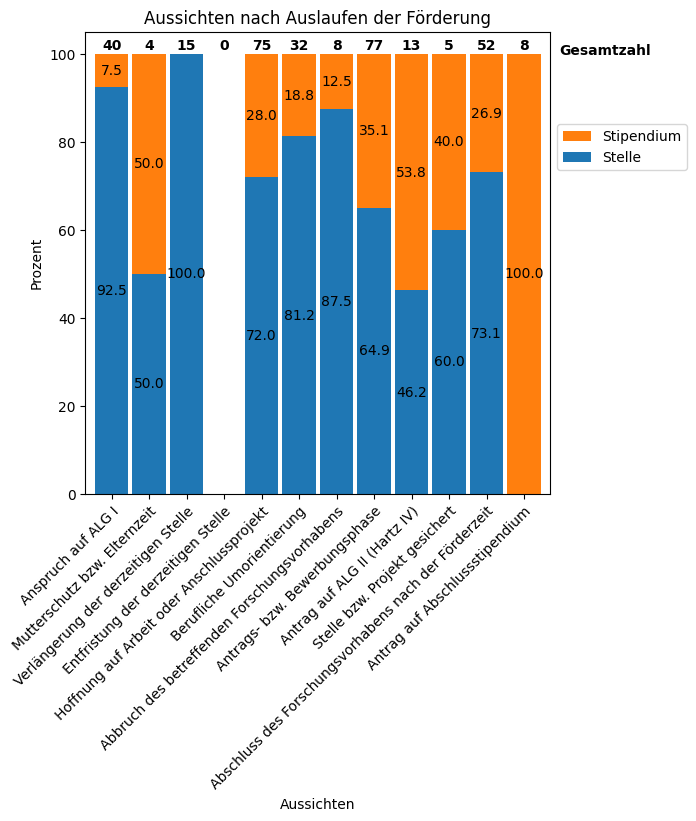

In [622]:
ax = DR_expec_df[DR_expec_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(6, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Aussichten',
                        width=0.9,
                        title='Aussichten nach Auslaufen der Förderung'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(unique_entries, rotation=45, ha='right', rotation_mode='anchor')
inversed_legend(levels_university_stipend)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(DR_expec_df['totals']):
    ax.text(DR_expec_df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [623]:
DR_expec_T_df, DR_expec_T_perc = cross_analysis_one_hot([UH_career, S_career], unique_entries, df=df_new)
DR_expec_T_df

,Anspruch auf ALG I,Mutterschutz bzw. Elternzeit,Verlängerung der derzeitigen Stelle,Entfristung der derzeitigen Stelle,Hoffnung auf Arbeit oder Anschlussprojekt,Berufliche Umorientierung,Abbruch des betreffenden Forschungsvorhabens,Antrags- bzw. Bewerbungsphase,Antrag auf ALG II (Hartz IV),Stelle bzw. Projekt gesichert,...,Verlängerung der derzeitigen StellePercentage,Entfristung der derzeitigen StellePercentage,Hoffnung auf Arbeit oder AnschlussprojektPercentage,Berufliche UmorientierungPercentage,Abbruch des betreffenden ForschungsvorhabensPercentage,Antrags- bzw. BewerbungsphasePercentage,Antrag auf ALG II (Hartz IV)Percentage,Stelle bzw. Projekt gesichertPercentage,Abschluss des Forschungsvorhabens nach der FörderzeitPercentage,Antrag auf AbschlussstipendiumPercentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",37,2,15,0,54,26,7,50,6,3,...,6.302521,0.0,22.689076,10.924370,2.941176,21.008403,2.521008,1.260504,15.966387,0.000000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",3,2,0,0,21,6,1,27,7,2,...,0.000000,0.0,23.076923,6.593407,1.098901,29.670330,7.692308,2.197802,15.384615,8.791209


Text(1.02, 0.5, 'Mehrfachnennung waren möglich')

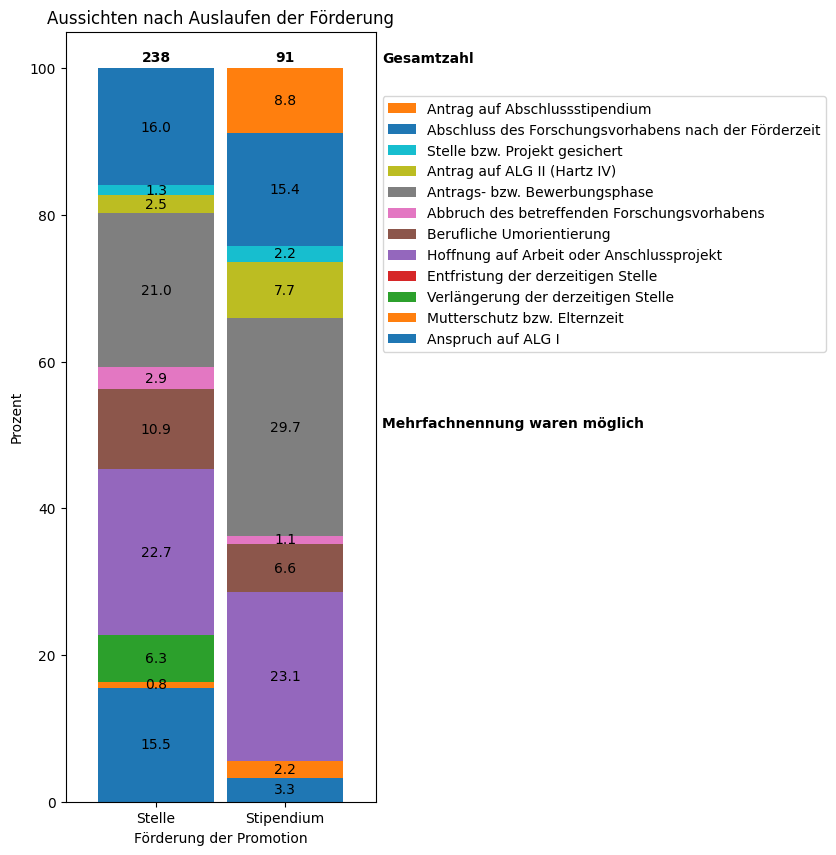

In [624]:
ax = DR_expec_T_df[DR_expec_T_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(4, 10),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Förderung der Promotion',
                        width=0.9,
                        title='Aussichten nach Auslaufen der Förderung'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Stelle', 'Stipendium'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(unique_entries)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(DR_expec_T_df['totals']):
    ax.text(DR_expec_T_df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
ax.text(1.02, 0.5, 'Mehrfachnennung waren möglich', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [625]:
fig = ax.get_figure()
fig.savefig('../reports/figures/DR_03_Aussichten_nach_Förderung.png', bbox_inches='tight', dpi=300)

<Axes: ylabel='Frequency'>

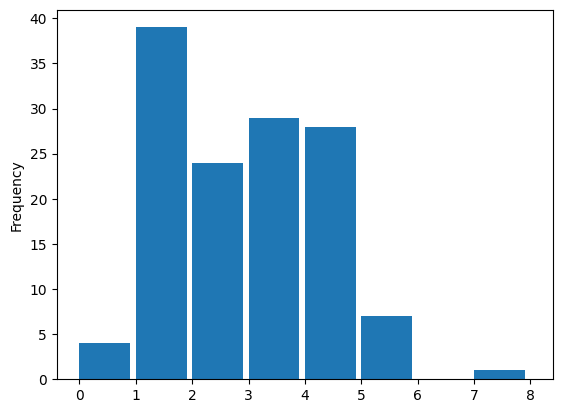

In [626]:
# plot distribution of number of entries for plans after dissertation support
df_new[unique_entries].sum(axis=1).plot(kind='hist',
                                        bins=8,
                                        width=0.9)

### looking for work before diss?

In [627]:
jobless_DR_df, jobless_DR_perc = cross_analysis_non_one_hot('AP7. Waren Sie als Kunstwissenschaftler:in arbeitssuchend?\xa0', [UH_career, S_career], df=DR_df, transpose=True)

In [628]:
jobless_DR_df

,AP7. Waren Sie als Kunstwissenschaftler:in arbeitssuchend? _0.0_sum,AP7. Waren Sie als Kunstwissenschaftler:in arbeitssuchend? _1.0_sum,totals,AP7. Waren Sie als Kunstwissenschaftler:in arbeitssuchend? _0.0_sumPerc,AP7. Waren Sie als Kunstwissenschaftler:in arbeitssuchend? _1.0_sumPerc
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",44.0,49.0,93.0,47.311828,52.688172
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",17.0,20.0,37.0,45.945946,54.054054


Text(1.02, 0.975, 'Gesamtzahl')

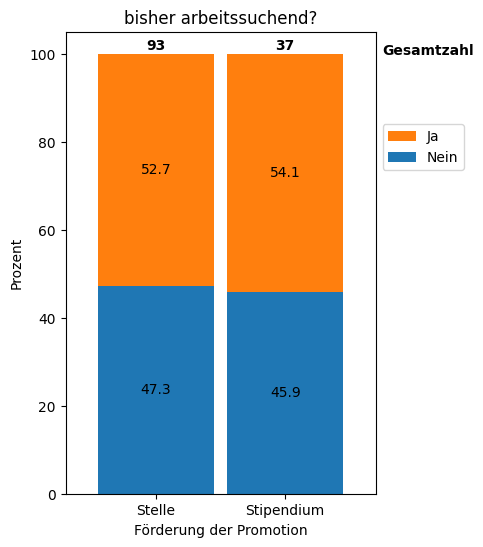

In [629]:
ax = jobless_DR_df[jobless_DR_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(4, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Förderung der Promotion',
                        width=0.9,
                        title='bisher arbeitssuchend?'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Stelle', 'Stipendium'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(levels_no_yes)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(jobless_DR_df['totals']):
    ax.text(jobless_DR_df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [630]:
fig = ax.get_figure()
fig.savefig('../reports/figures/DR_04_Arbeitssuchend.png', bbox_inches='tight', dpi=300)

### Gender Stips vs. University

In [631]:
DR_gender_df, DR_gender_perc = cross_analysis_one_hot([UH_career, S_career], ls_cols_gender, df=DR_df)
DR_gender_df

,CO6. Welchem Geschlecht ordnen Sie sich zu?_Divers,CO6. Welchem Geschlecht ordnen Sie sich zu?_Männlich,CO6. Welchem Geschlecht ordnen Sie sich zu?_Weiblich,totals,CO6. Welchem Geschlecht ordnen Sie sich zu?_DiversPercentage,CO6. Welchem Geschlecht ordnen Sie sich zu?_MännlichPercentage,CO6. Welchem Geschlecht ordnen Sie sich zu?_WeiblichPercentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",1,13,80,94,1.063830,13.829787,85.106383
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",1,5,32,38,2.631579,13.157895,84.210526


Text(1.02, 0.975, 'Gesamtzahl')

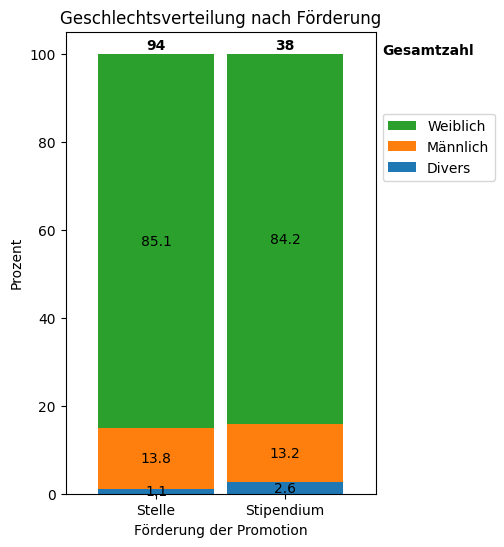

In [632]:
ax = DR_gender_df[DR_gender_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(4, 6),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Förderung der Promotion',
                        width=0.9,
                        title='Geschlechtsverteilung nach Förderung'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Stelle', 'Stipendium'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(gender_levels)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(DR_gender_df['totals']):
    ax.text(DR_gender_df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [633]:
fig = ax.get_figure()
fig.savefig('../reports/figures/DR_05_Gender.png', bbox_inches='tight', dpi=300)

### pandemic effect

In [634]:
cols_pand_effect = [col for col in DR_df.columns if col.startswith('CO10')]
pand_effect_levels = [extract_last_bracket(item) for item in cols_pand_effect]
pand_effect_df, pand_effect_perc = cross_analysis_one_hot([UH_career, S_career], cols_pand_effect, df=DR_df)
pand_effect_df

,CO10[SQ001]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Aufweichung von Grenzen zwischen “Work and Life”],"CO10[SQ002]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Geplante Projekte können nicht realisiert werden (z.B. Tagungen, Festivals, Forschungsprojekte, Ausstellungen)]",CO10[SQ003]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Geplante Projekte mussten konzeptionell verändert werden],CO10[SQ004]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Keine Einarbeitung in Präsenz],CO10[SQ005]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Konflikt zwischen beruflichen Verpflichtungen und Betreuungsverpflichtungen],CO10[SQ006]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Wegfall von Netzwerken],CO10[SQ007]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Wegfall von Nebeneinkünften],CO10[SQ008]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Verschiebung von Antrittszeiten],totals,CO10[SQ001]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Aufweichung von Grenzen zwischen “Work and Life”]Percentage,"CO10[SQ002]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Geplante Projekte können nicht realisiert werden (z.B. Tagungen, Festivals, Forschungsprojekte, Ausstellungen)]Percentage",CO10[SQ003]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Geplante Projekte mussten konzeptionell verändert werden]Percentage,CO10[SQ004]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Keine Einarbeitung in Präsenz]Percentage,CO10[SQ005]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Konflikt zwischen beruflichen Verpflichtungen und Betreuungsverpflichtungen]Percentage,CO10[SQ006]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Wegfall von Netzwerken]Percentage,CO10[SQ007]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Wegfall von Nebeneinkünften]Percentage,CO10[SQ008]. Welche weiteren Auswirkungen hatte die Corona-Pandemie auf Ihre Arbeit? [Verschiebung von Antrittszeiten]Percentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",79,70,49,34,22,67,11,4,336,23.511905,20.833333,14.583333,10.119048,6.547619,19.940476,3.273810,1.190476
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",29,32,19,11,6,33,9,4,143,20.279720,22.377622,13.286713,7.692308,4.195804,23.076923,6.293706,2.797203


Text(1.02, 0.5, 'Mehrfachnennung waren möglich')

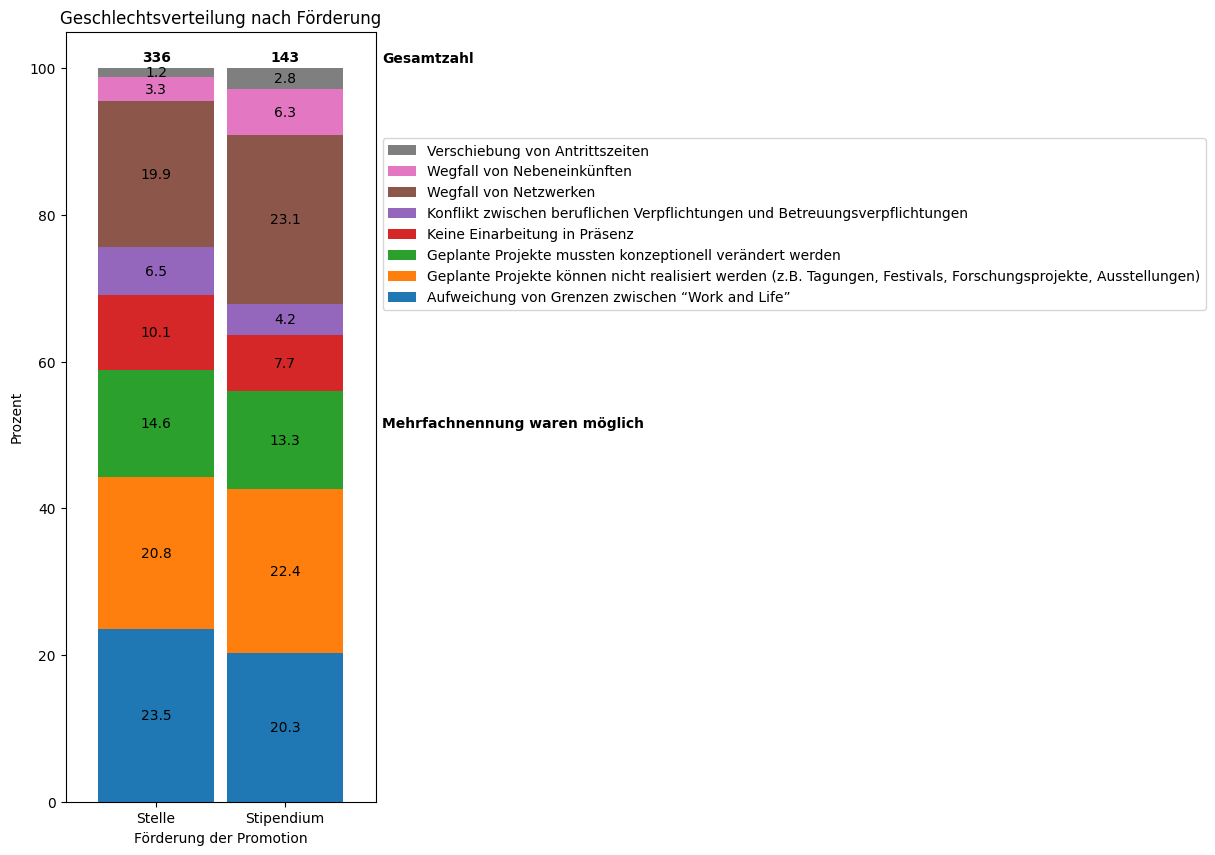

In [635]:
ax = pand_effect_df[pand_effect_perc].plot(kind='bar', 
                        stacked=True, 
                        figsize=(4, 10),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Förderung der Promotion',
                        width=0.9,
                        title='Geschlechtsverteilung nach Förderung'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Stelle', 'Stipendium'], rotation=0, ha='center', rotation_mode='anchor')
inversed_legend(pand_effect_levels)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(pand_effect_df['totals']):
    ax.text(pand_effect_df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
ax.text(1.02, 0.5, 'Mehrfachnennung waren möglich', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [636]:
fig = ax.get_figure()
fig.savefig('../reports/figures/DR_06_Auswirkungen_Pandemie.png', bbox_inches='tight', dpi=300)

<Axes: ylabel='Frequency'>

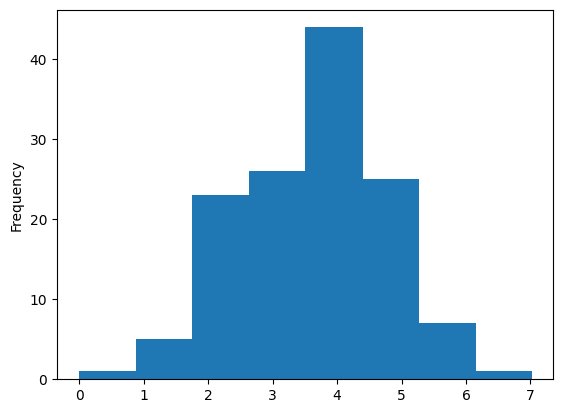

In [637]:
# plot distribution of number of entries for plans after dissertation support
DR_df[cols_pand_effect].sum(axis=1).plot(kind='hist',
                                        bins=8,
                                        width=0.9)